In [1]:
import warnings
import scanpy as sc
import squidpy as sq
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
import json
import os
from tqdm.notebook import tqdm

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

## Global variables

In [12]:
dir_path = '../data/filtered_adata/concated/'

In [13]:
os.listdir(dir_path)

['chimp.h5ad', 'human.h5ad', 'macaque.h5ad', 'spatial_libd_human.h5ad']

#  Make pseudobulk

In [4]:
for file_name in tqdm(os.listdir(dir_path)):
    file = file_name.split('.')[0]
    # read adata object
    adata = sc.read_h5ad(dir_path + file_name)
    adata.obs.label.replace({"L6a": "L6", "L6b": "L6"}, inplace=True)
    # add pseudobulk label
    adata.obs['pb_label'] = adata.obs.label.astype(str) + '.' + adata.obs.sample_id.astype(str)
    # create pseudobulk df
    sample_layer_list = adata.obs.pb_label.unique().tolist()
    # create pseudobulk sum df
    pb_sum_list = [adata[adata.obs.pb_label == sample].X.sum(axis=0) for sample in sample_layer_list]
    pb_sum_df = pd.DataFrame(np.concatenate(pb_sum_list).T, columns=sample_layer_list, index=adata.var_names)
    # create pseudobulk sum df
    pb_mean_list = [adata[adata.obs.pb_label == sample].X.mean(axis=0) for sample in sample_layer_list]
    pb_mean_df = pd.DataFrame(np.concatenate(pb_mean_list).T, columns=sample_layer_list, index=adata.var_names)
    # create annotation file
    columns = ['layer', 'sample_id']
    annotation_list = [sample.split('.') for sample in sample_layer_list]
    annotation = pd.DataFrame(annotation_list, index=sample_layer_list, columns=columns)
    annotation['condition'] = file
    #save files
    pb_sum_df.to_csv(f'../results/DiffExpr/pseudobulks/expression_sum_{file}.csv')
    pb_mean_df.to_csv(f'../results/DiffExpr/pseudobulks/expression_mean_{file}.csv')
    annotation.to_csv(f'../results/DiffExpr/pseudobulks/annotation_{file}.csv')

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
os.listdir('../results/DiffExpr/pseudobulks/')

['annotation_chimp.csv',
 'annotation_human.csv',
 'annotation_macaque.csv',
 'annotation_spatial_libd_human.csv',
 'expression_chimp.csv',
 'expression_human.csv',
 'expression_macaque.csv',
 'expression_mean_chimp.csv',
 'expression_mean_human.csv',
 'expression_mean_macaque.csv',
 'expression_mean_spatial_libd_human.csv',
 'expression_spatial_libd_human.csv',
 'expression_sum_chimp.csv',
 'expression_sum_human.csv',
 'expression_sum_macaque.csv',
 'expression_sum_spatial_libd_human.csv']

# Pseudobulk EDA

In [18]:
dir_path = '../data/pseudobulks/'
conditions = ['human', 'spatial_libd_human', 'chimp', 'macaque']

adata_dict = dict()
expr_sum_dict = dict()
expr_mean_dict = dict()
ann_dict = dict()

for condition in tqdm(conditions):
    expr_sum_dict[condition] = pd.read_csv(dir_path + f'expression_sum_{condition}.csv', index_col=0)
    expr_mean_dict[condition] = pd.read_csv(dir_path + f'expression_mean_{condition}.csv', index_col=0)
    ann_dict[condition] = pd.read_csv(dir_path + f'annotation_{condition}.csv', index_col=0)
    
    adata_sum = an.AnnData(expr_sum_dict[condition].T)
    adata_sum.obs = ann_dict[condition]
    adata_dict[condition + '_sum'] = adata_sum
    
    adata_mean = an.AnnData(expr_mean_dict[condition].T)
    adata_mean.obs = ann_dict[condition]
    adata_dict[condition + '_mean'] = adata_mean

  0%|          | 0/4 [00:00<?, ?it/s]

## Mean aggregation

In [58]:
adata_pb_dict = dict()
agg = 'mean'
mamm_cond = ['human', 'chimp', 'macaque']
age_cond = ['human', 'spatial_libd_human']

# млекопитающие
adata_pb_dict[f'mamm_{agg}'] = an.concat([adata_dict[cond + f'_{agg}'] for cond in mamm_cond], merge='same')
# человеки
adata_pb_dict[f'age_{agg}'] = an.concat([adata_dict[cond + f'_{agg}'] for cond in age_cond], merge='same')
# всё вместе
adata_pb_dict[agg] = an.concat([adata_dict[cond + f'_{agg}'] for cond in conditions], merge='same')

In [59]:
adata_pb_dict

{'mamm_mean': AnnData object with n_obs × n_vars = 94 × 15585
     obs: 'layer', 'sample_id', 'condition',
 'age_mean': AnnData object with n_obs × n_vars = 111 × 19404
     obs: 'layer', 'sample_id', 'condition',
 'mean': AnnData object with n_obs × n_vars = 170 × 15367
     obs: 'layer', 'sample_id', 'condition'}

In [60]:
adata_pb = adata_pb_dict[agg].copy()

In [61]:
# глубина секвенирования
adata_pb.obs["lib_size"] = adata_pb.X.sum(axis=1)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"])

### Counts

Визуализируем чистые псевдобалки

computing PCA
    with n_comps=50
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


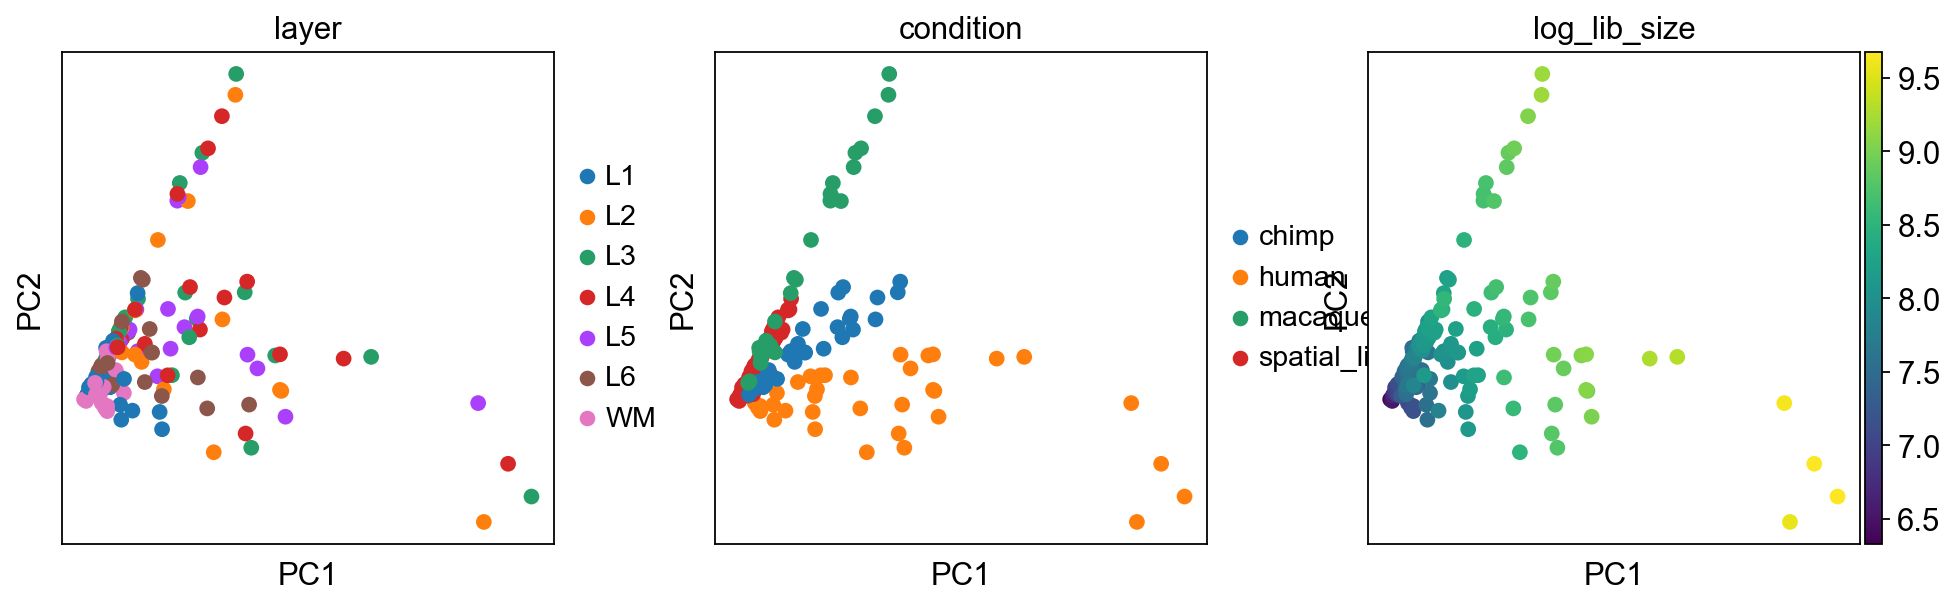

In [62]:
sc.pp.pca(adata_pb)
sc.pl.pca(adata_pb, color=['layer', 'condition', 'log_lib_size'], size=200, ncols=3)

  0%|          | 0/4 [00:00<?, ?it/s]

computing PCA
    with n_comps=34
    finished (0:00:00)
computing PCA
    with n_comps=50


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


    finished (0:00:00)
computing PCA
    with n_comps=30
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


computing PCA
    with n_comps=27
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


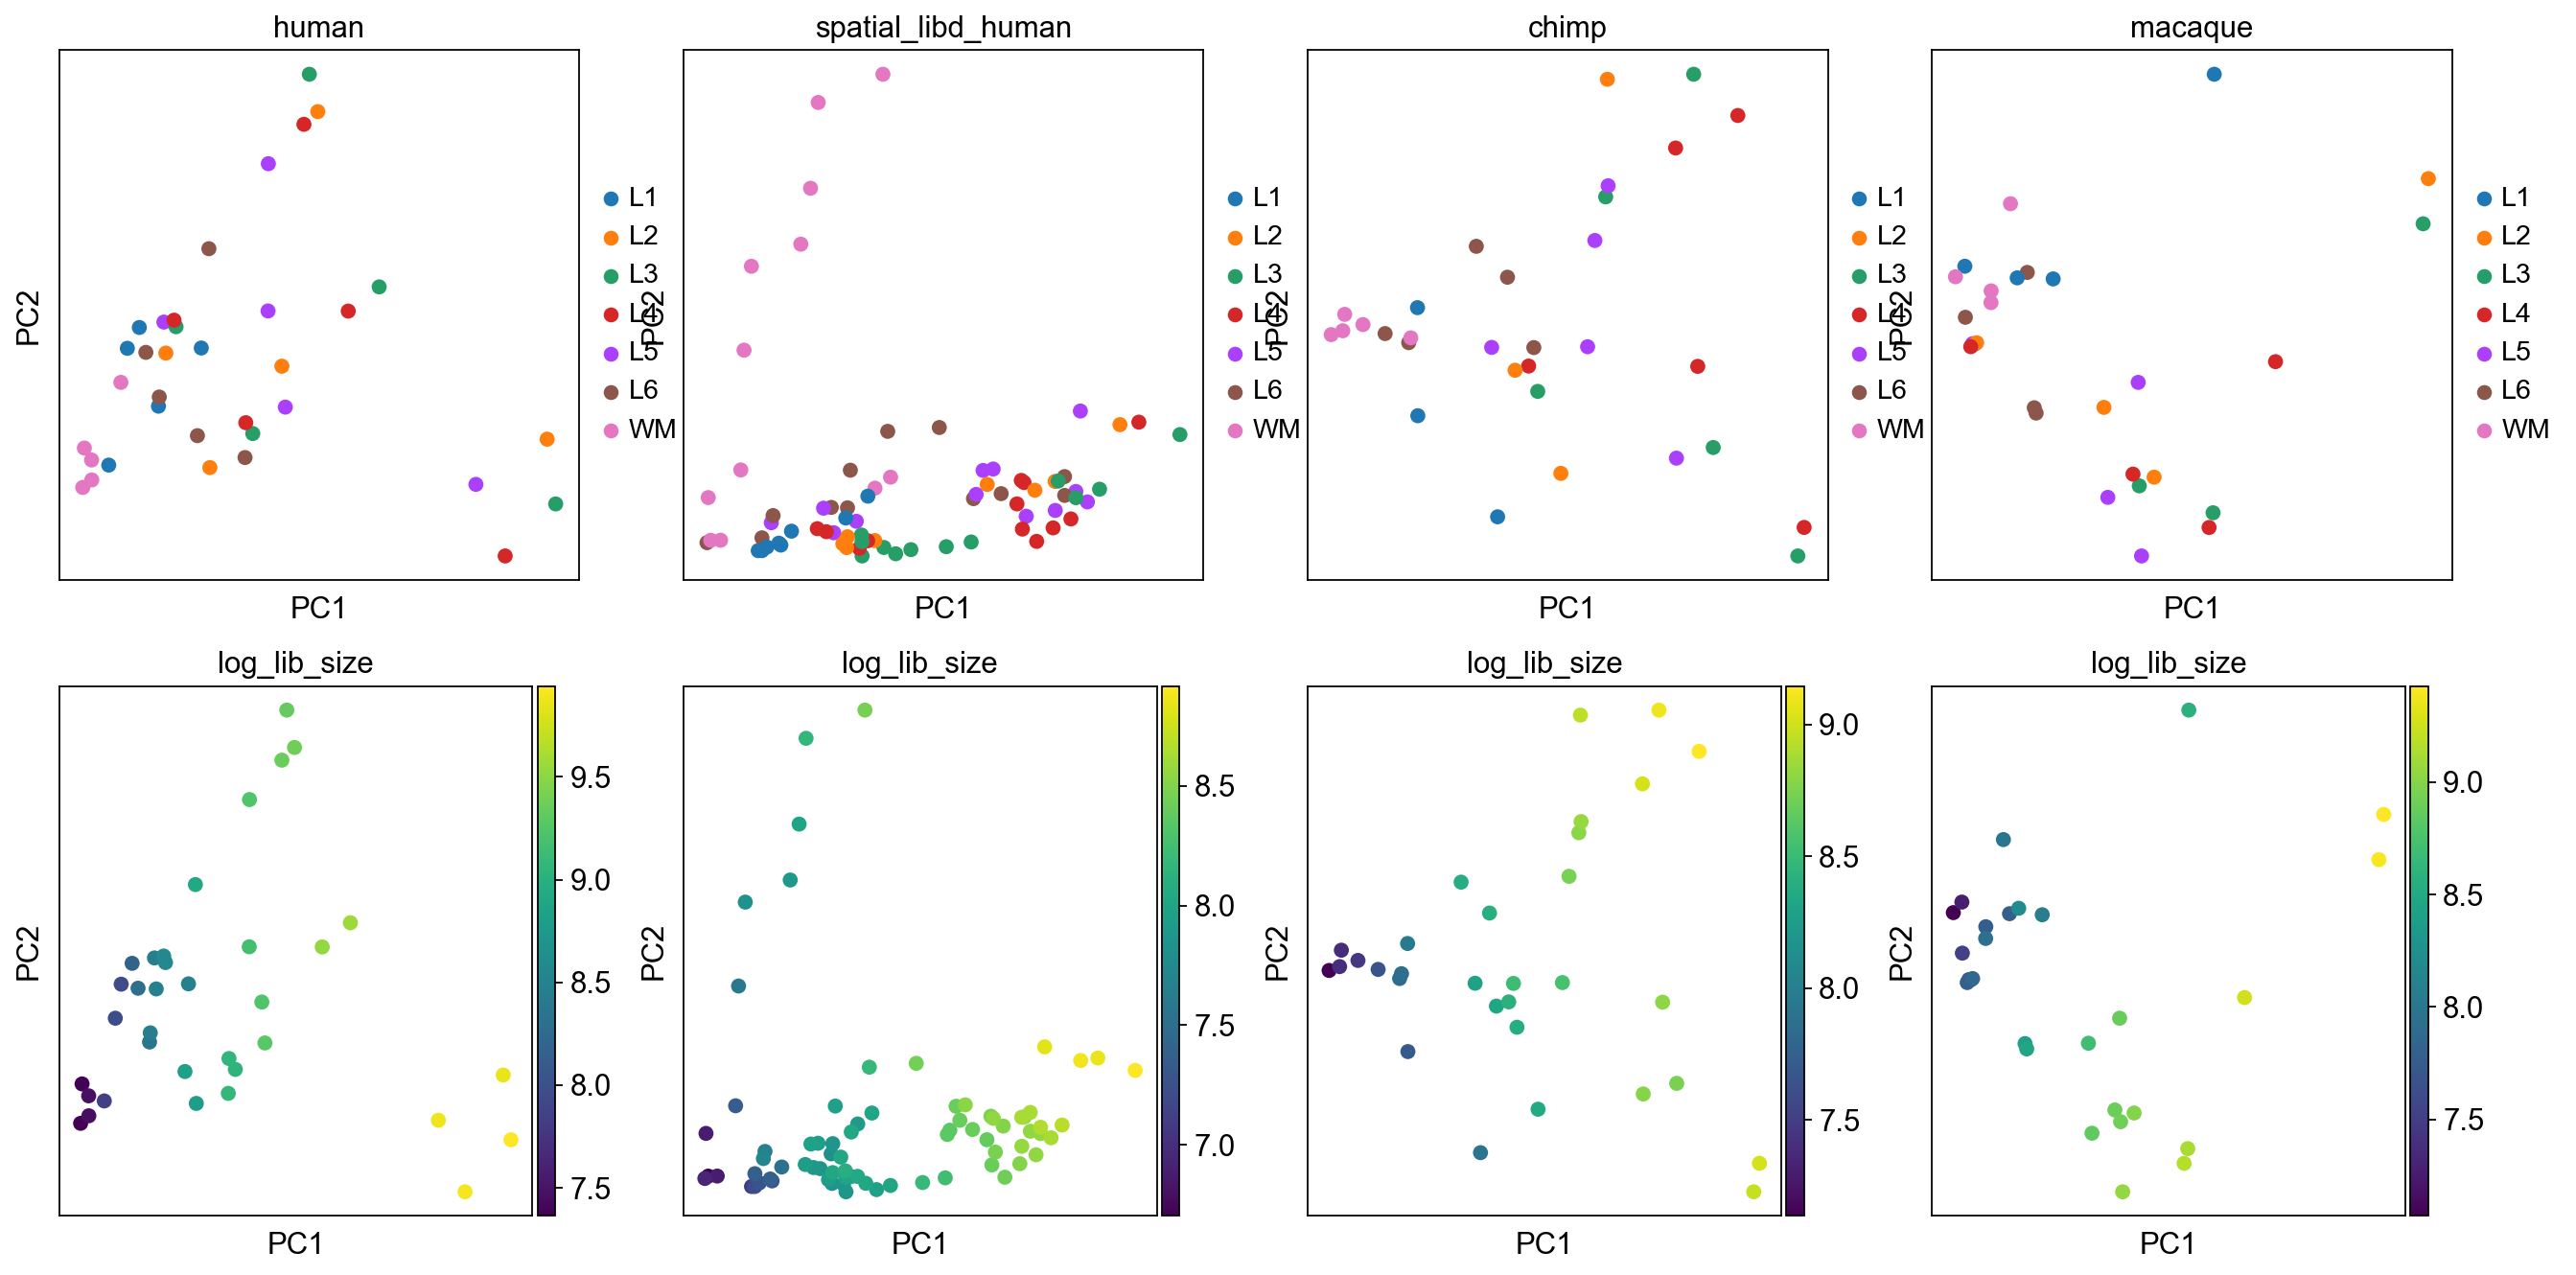

In [63]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

for i, condition in enumerate(tqdm(conditions)):
    # load data
    adata = adata_dict[condition + f'_{agg}'].copy()
    # calculate lib size
    adata.obs["lib_size"] = adata.X.sum(axis=1)
    adata.obs["log_lib_size"] = np.log(adata.obs["lib_size"])
    # calculate pca
    sc.pp.pca(adata)
    # plot pca
    sc.pl.pca(adata, color=['layer'], size=200, ax=ax[0][i], show=False, title=condition)
    sc.pl.pca(adata, color=['log_lib_size'], size=200, ax=ax[1][i], show=False)

### Log(counts)

Визуализируем логарифмированые псевдобалки

In [64]:
adata_pb.raw = adata_pb
#sc.pp.normalize_total(adata_pb_sum, target_sum=1e4)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)

computing PCA
    with n_comps=50
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


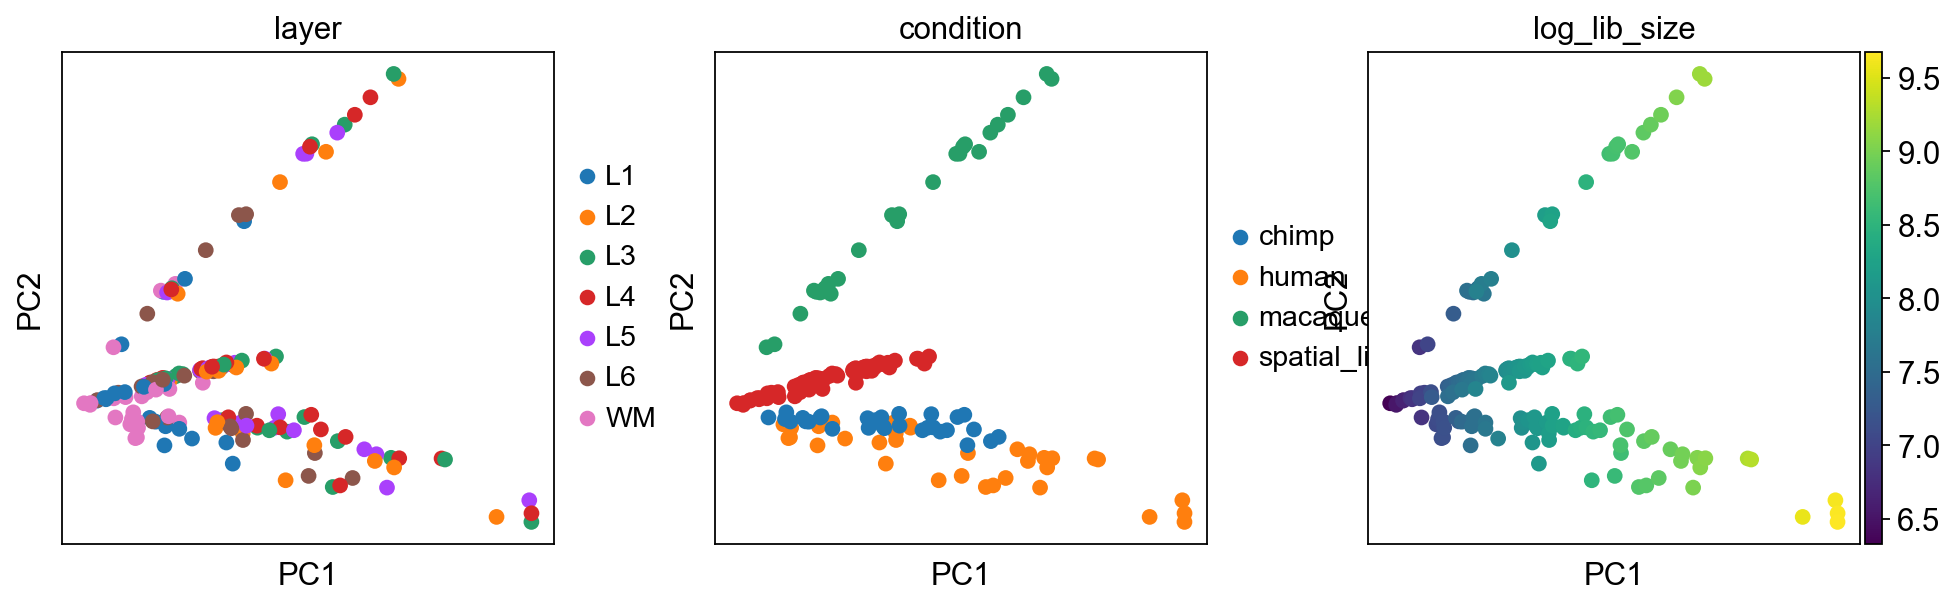

In [65]:
sc.pl.pca(adata_pb, color=['layer', 'condition', 'log_lib_size'], size=200, ncols=3)

  0%|          | 0/4 [00:00<?, ?it/s]

computing PCA
    with n_comps=34
    finished (0:00:00)
computing PCA
    with n_comps=50


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


    finished (0:00:00)
computing PCA
    with n_comps=30
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


computing PCA
    with n_comps=27
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


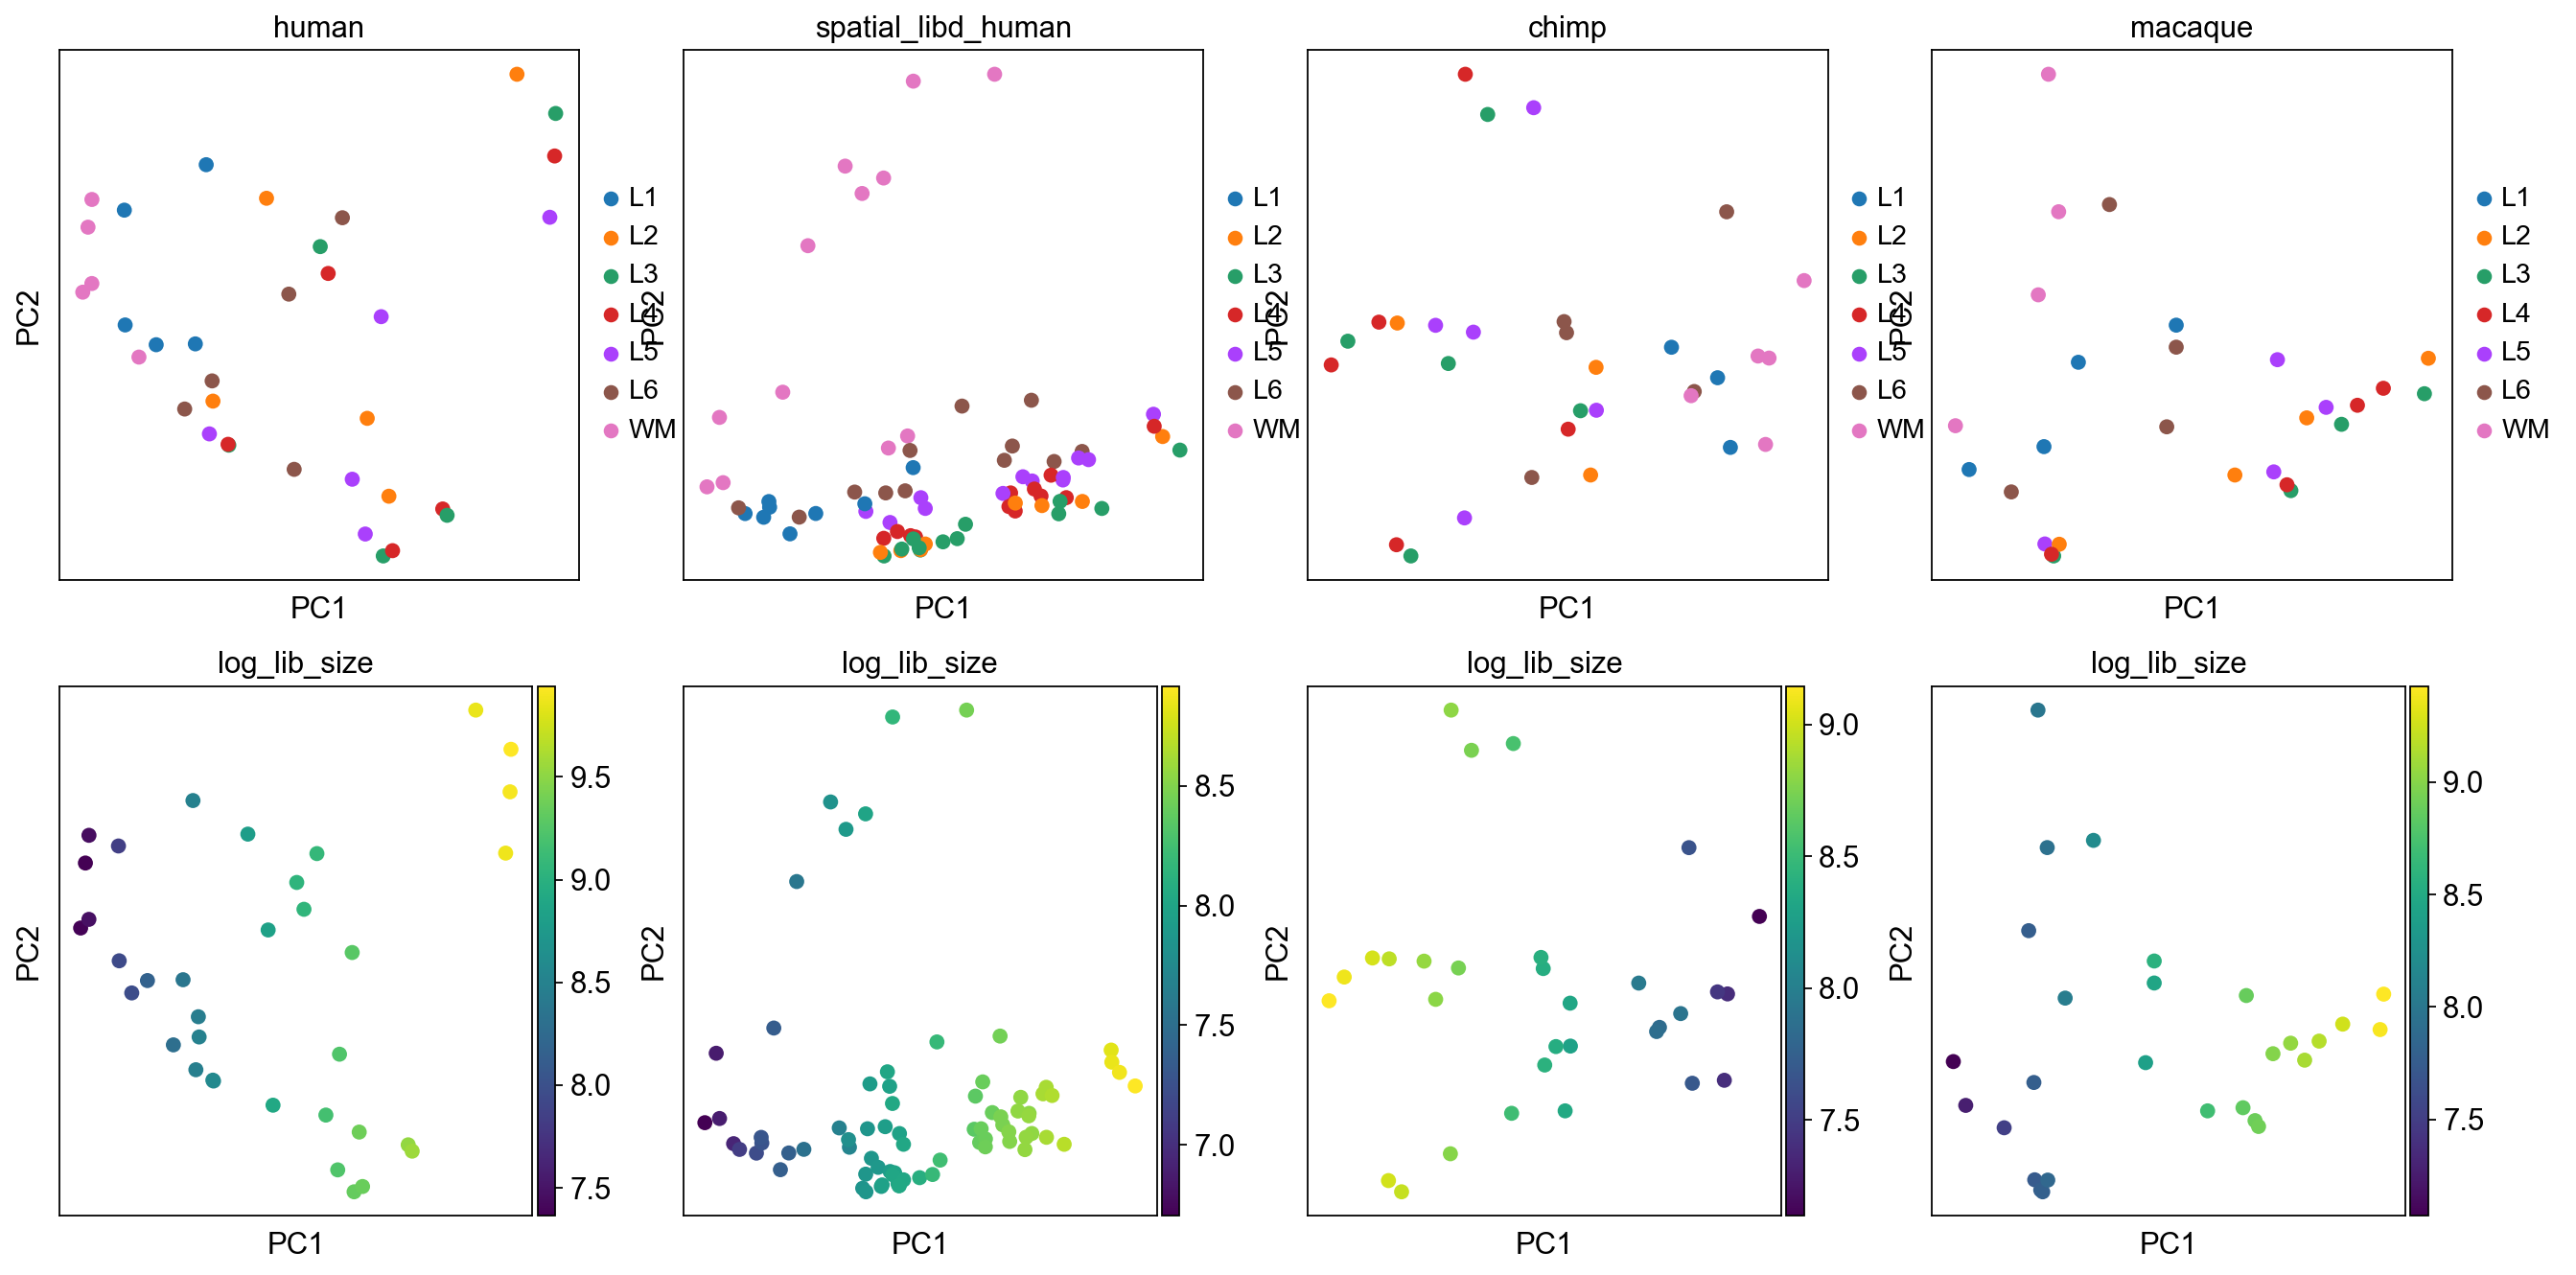

In [66]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

for i, condition in enumerate(tqdm(conditions)):
    # load data
    adata = adata_dict[condition + f'_{agg}'].copy()
    # calculate lib size
    adata.obs["lib_size"] = adata.X.sum(axis=1)
    adata.obs["log_lib_size"] = np.log(adata.obs["lib_size"])
    # calculate pca
    sc.pp.log1p(adata)
    sc.pp.pca(adata)
    # plot pca
    sc.pl.pca(adata, color=['layer'], size=200, ax=ax[0][i], show=False, title=condition)
    sc.pl.pca(adata, color=['log_lib_size'], size=200, ax=ax[1][i], show=False)

### Log(CPM)

Визуализируем псевдобалки нормализованые на глубину библиотеки

In [67]:
adata_pb = adata_pb_dict[agg].copy()
adata_pb.obs["lib_size"] = adata_pb.X.sum(axis=1)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"])

In [68]:
sc.pp.normalize_total(adata_pb, target_sum=1e4)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


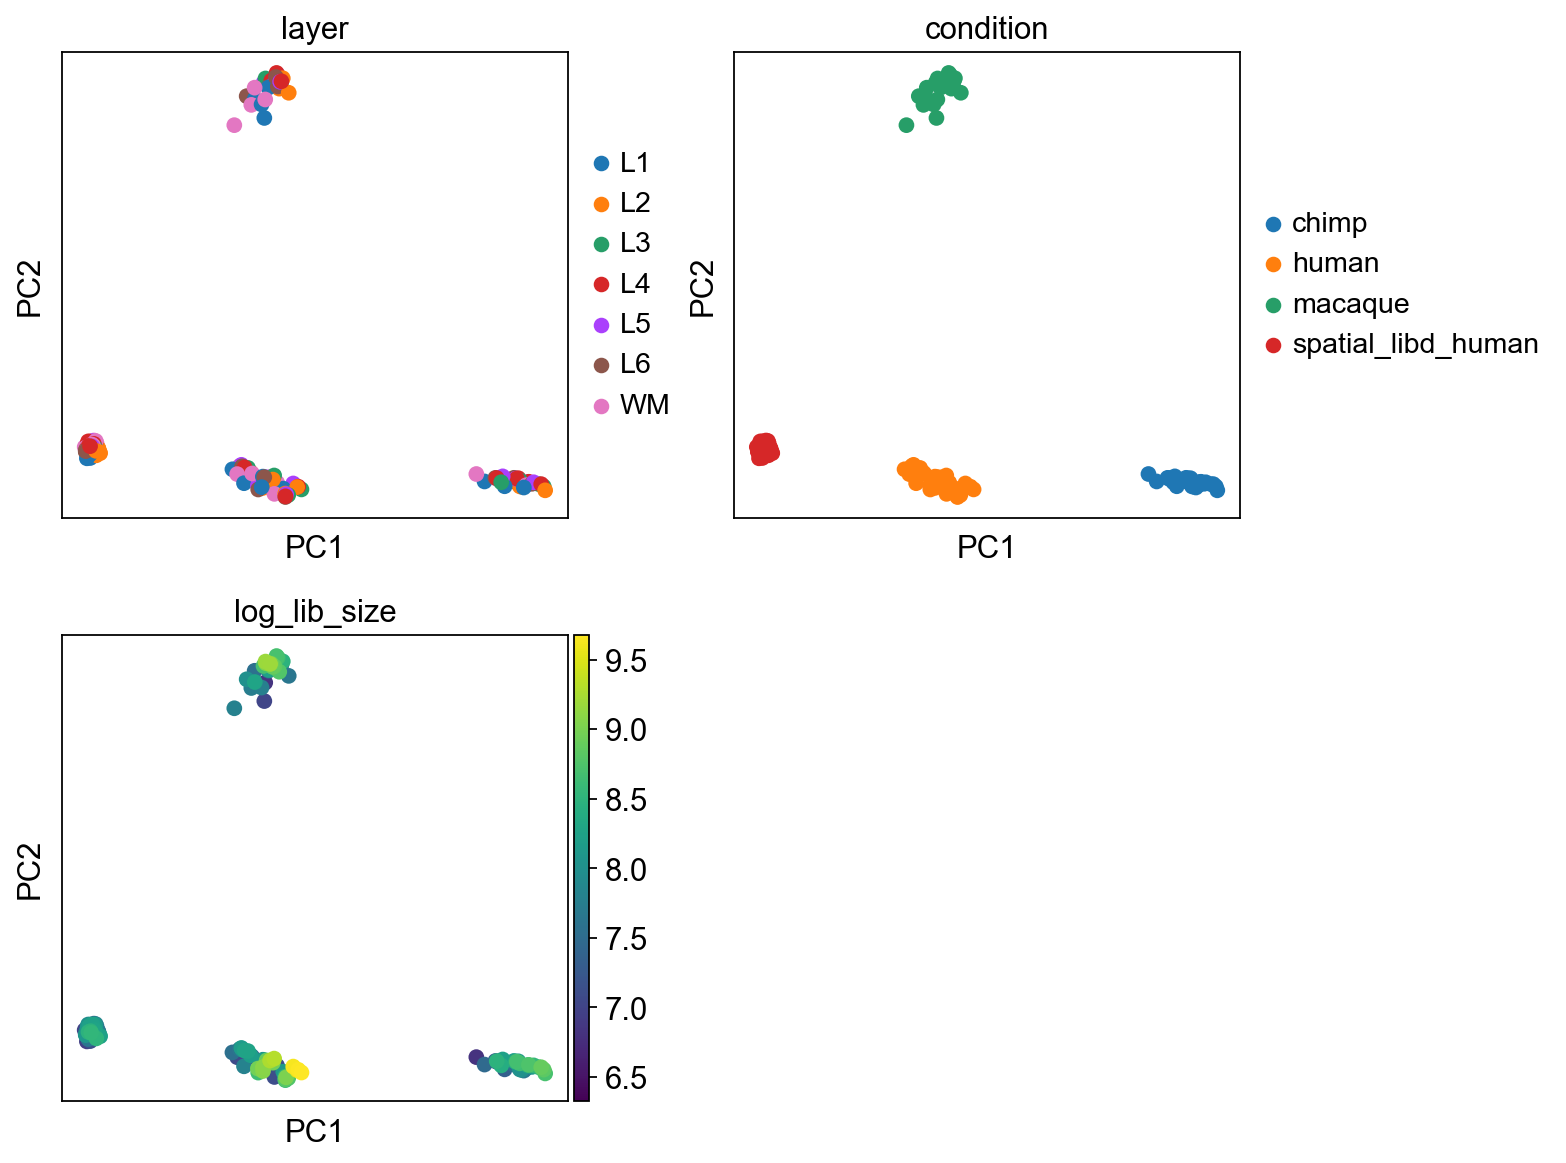

In [69]:
sc.pl.pca(adata_pb, color=['layer', 'condition', 'log_lib_size'], size=200, ncols=2)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


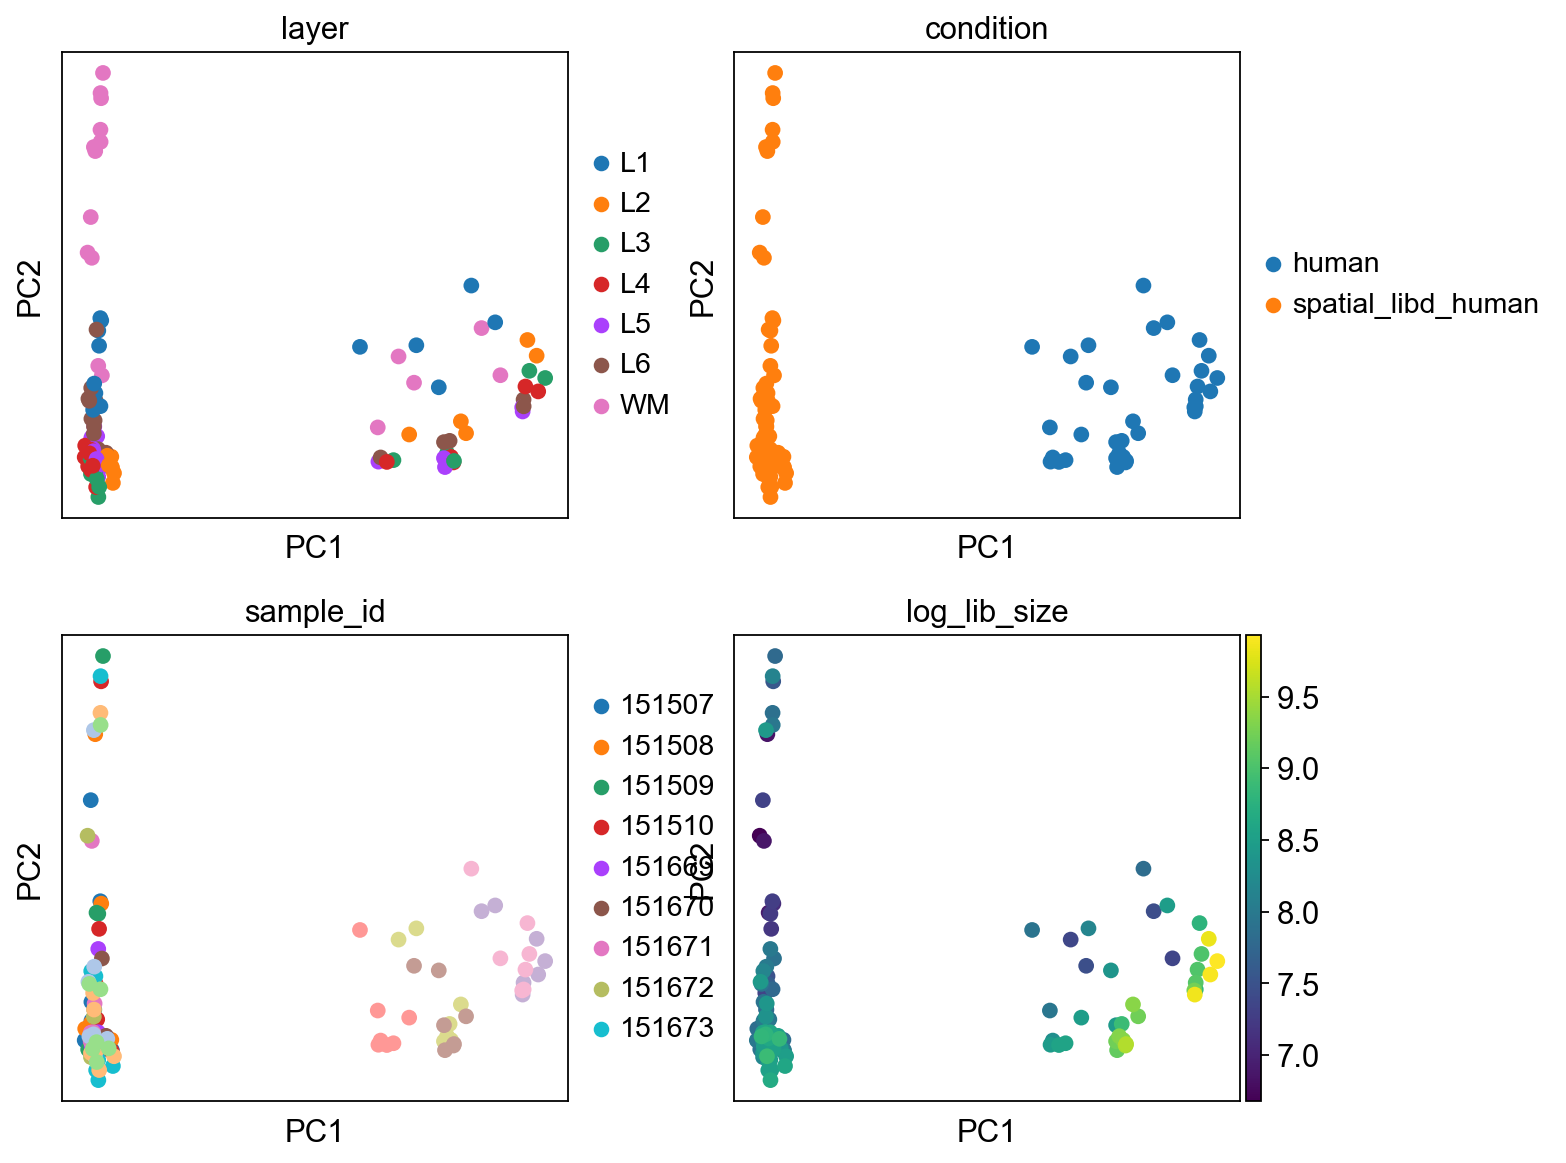

In [70]:
adata_pb = adata_pb_dict['age_mean'].copy()
adata_pb.raw = adata_pb

adata_pb.obs["lib_size"] = adata_pb.X.sum(axis=1)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"])
adata_pb.obs.sample_id = adata_pb.obs.sample_id.astype(str)

sc.pp.normalize_total(adata_pb, target_sum=1e4)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)

sc.pl.pca(adata_pb, color=['layer', 'condition', 'sample_id', 'log_lib_size'], size=200, ncols=2)

  0%|          | 0/4 [00:00<?, ?it/s]

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=34
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=30
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=27
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


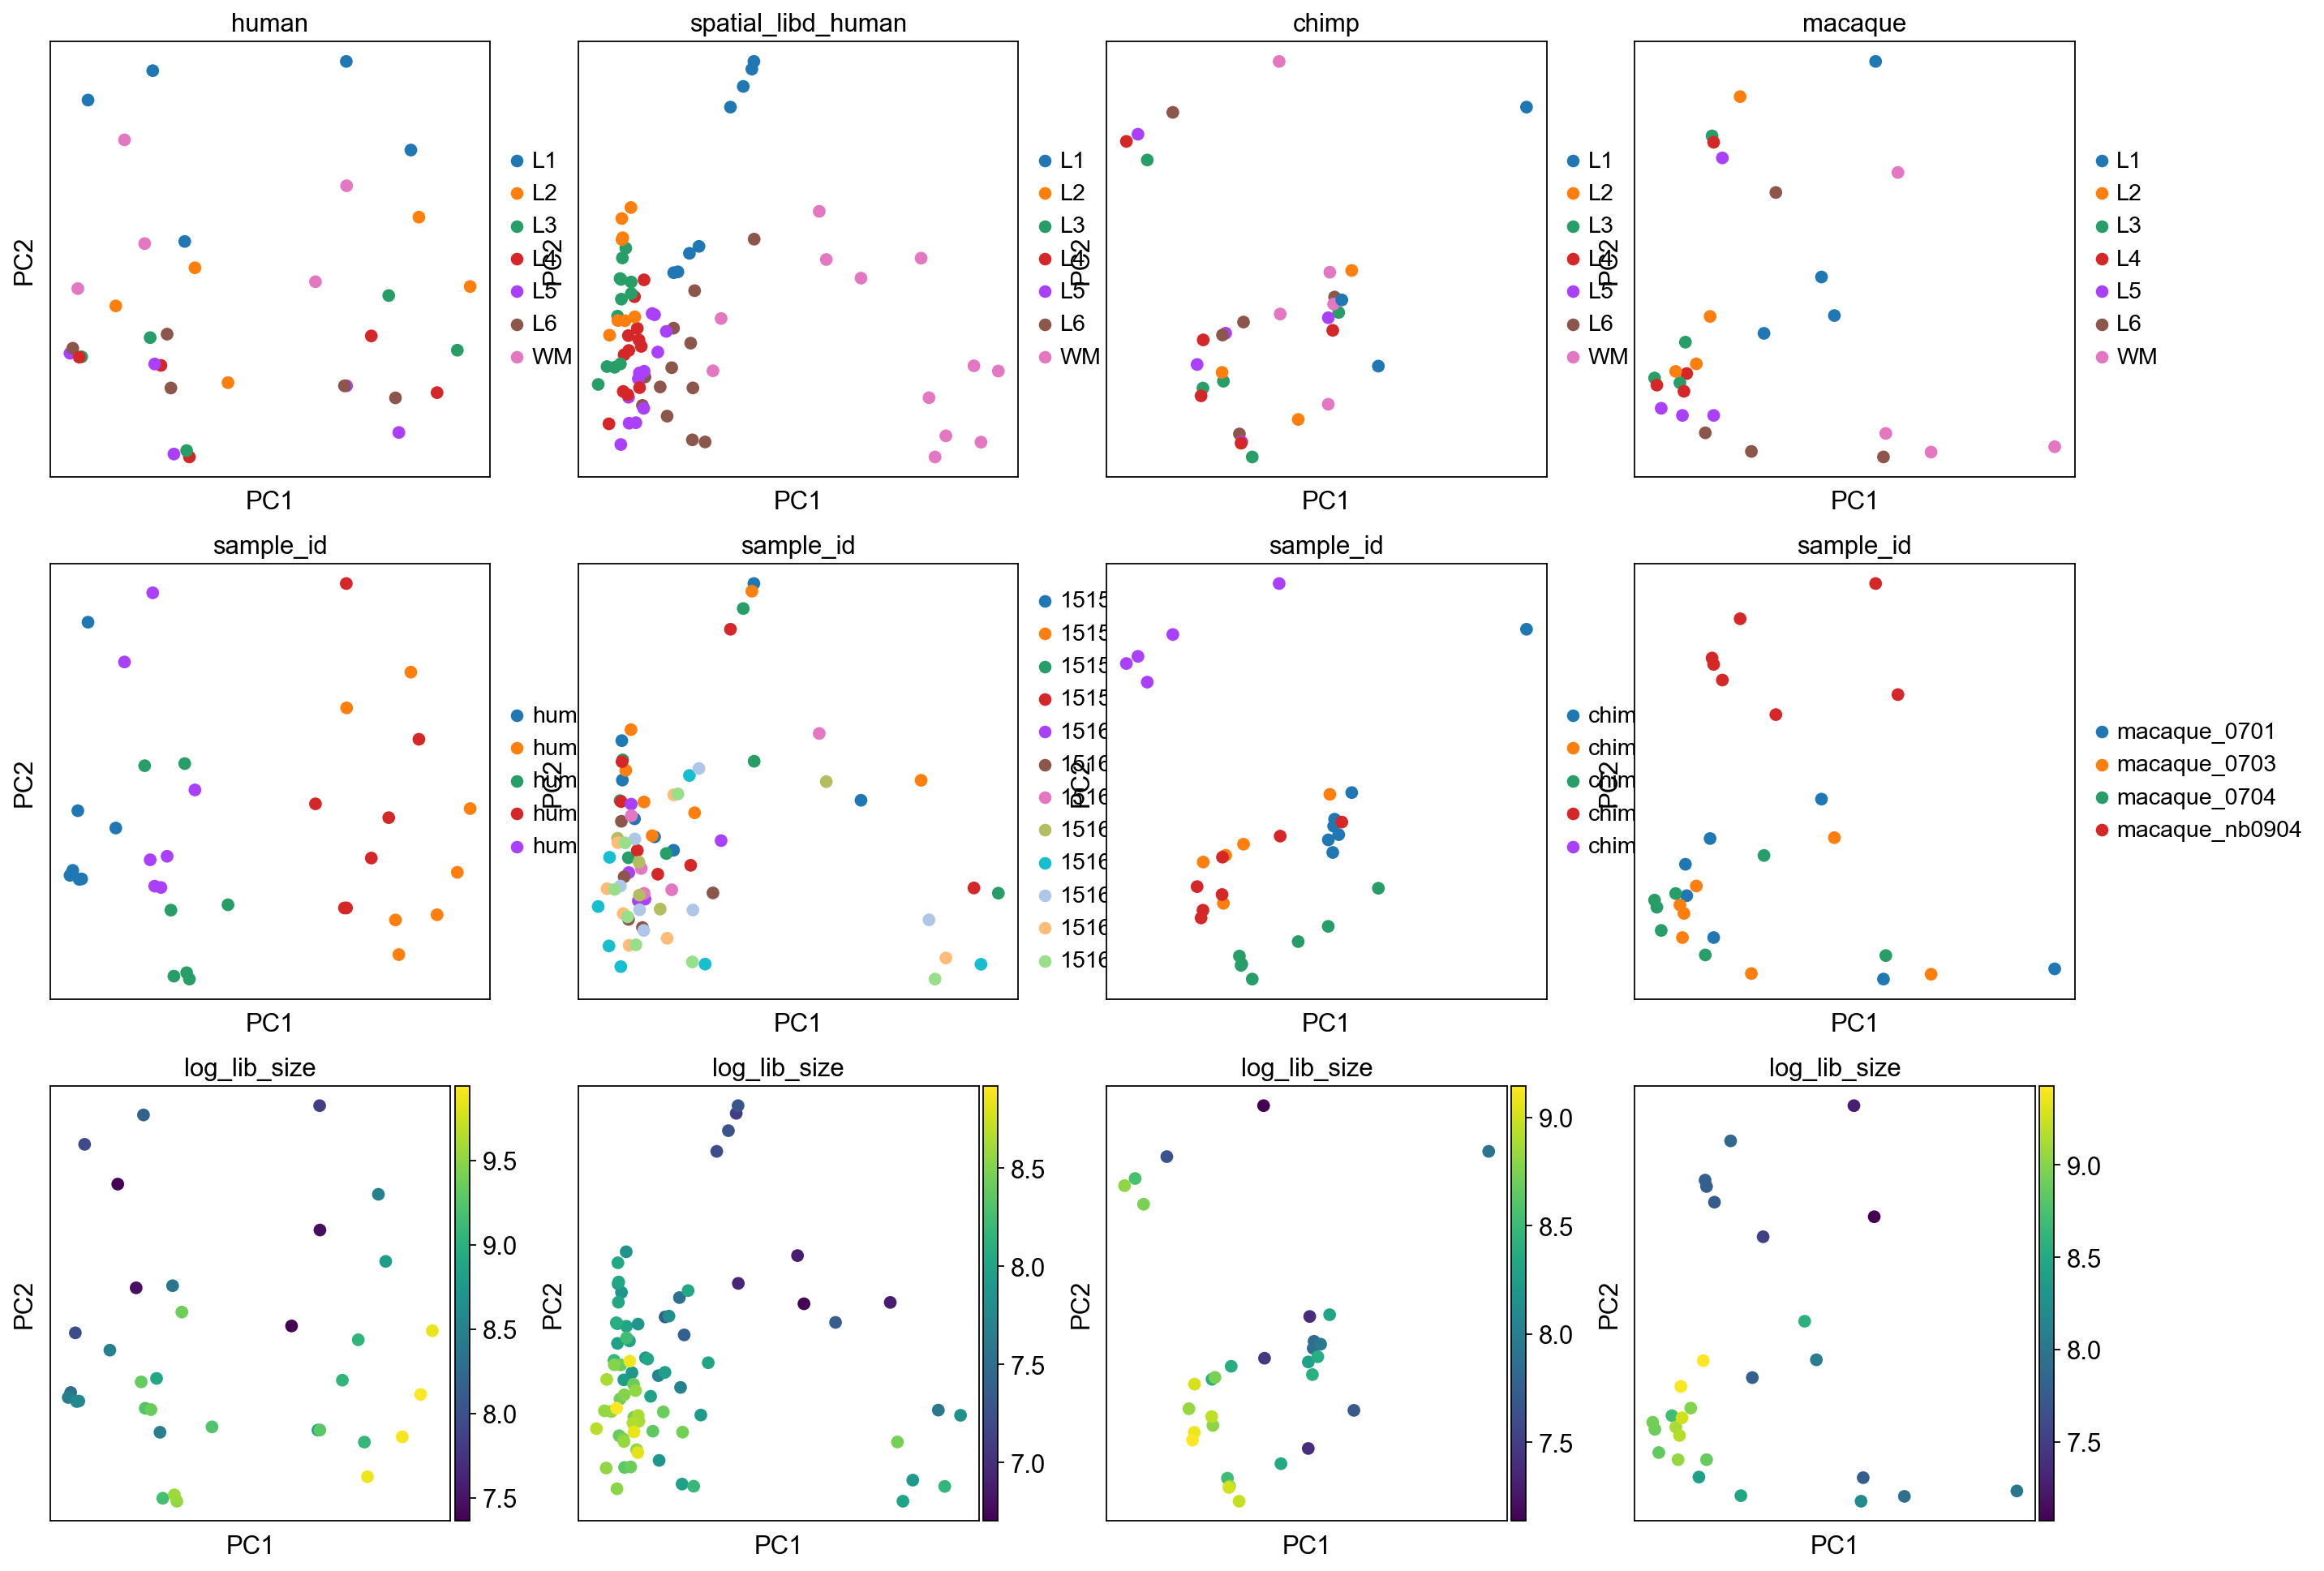

In [71]:
fig, ax = plt.subplots(3, 4, figsize=(20, 15))

for i, condition in enumerate(tqdm(conditions)):
    # load data
    adata = adata_dict[condition + f'_{agg}'].copy()
    adata.obs['sample_id'] = adata.obs['sample_id'].astype(str)
    # calculate lib size
    adata.obs["lib_size"] = adata.X.sum(axis=1)
    adata.obs["log_lib_size"] = np.log(adata.obs["lib_size"])
    # normalize and calculate pca
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.pca(adata)
    # plot pca
    sc.pl.pca(adata, color=['layer'], size=200, ax=ax[0][i], show=False, title=condition)
    sc.pl.pca(adata, color=['sample_id'], size=200, ax=ax[1][i], show=False)
    sc.pl.pca(adata, color=['log_lib_size'], size=200, ax=ax[2][i], show=False)

## Normalized sum

### counts - mean(counts)

Вычтем из каждого образца псевдобалка (образец.слой) среднюю экспрессию образца

In [91]:
adata_pb = adata_pb_dict[agg].copy()
adata_pb.obs["lib_size"] = adata_pb.X.sum(axis=1)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"])

In [92]:
adata_norm = adata_pb.copy()

In [93]:
def subtract_mean(adata):
    # calculate mean gene expr for each sample
    gene_mean_list = []
    sample_layer_list = adata.obs.sample_id.unique().tolist()
    for sample in sample_layer_list:
        gene_mean_list.append(adata[adata.obs.sample_id == sample].X.mean(axis=0).reshape(-1, 1))
    # convert to DataFrame
    gene_mean_df = pd.DataFrame(np.concatenate(gene_mean_list, axis=1), columns=sample_layer_list, index=adata.var_names)
    gene_mean_df.head()
    
    # subtract mean and return adata
    for sample in sample_layer_list:
        columns = adata.obs[adata.obs.sample_id == sample].index.to_list()
        for column in columns:
            adata[column].X = adata[column].X - gene_mean_df.loc[:, sample].values
    return adata

In [94]:
adata_norm = subtract_mean(adata_pb)

In [95]:
sc.pp.pca(adata_norm)

computing PCA
    with n_comps=50
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


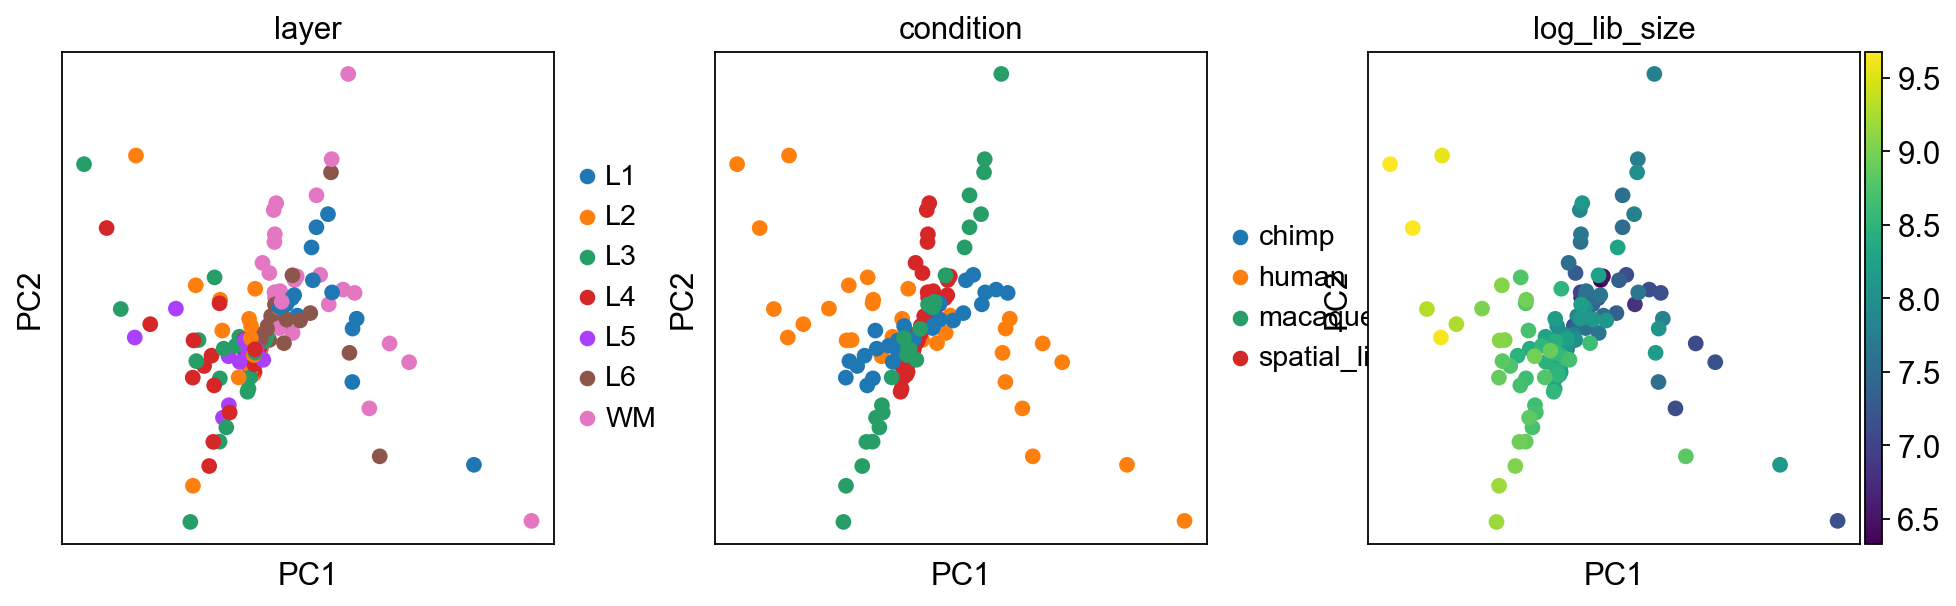

In [96]:
sc.pl.pca(adata_norm, color=['layer', 'condition', 'log_lib_size'], size=200, ncols=3)

  0%|          | 0/4 [00:00<?, ?it/s]

computing PCA
    with n_comps=34
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


computing PCA
    with n_comps=50
    finished (0:00:00)
computing PCA


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


    with n_comps=30
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


computing PCA
    with n_comps=27
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


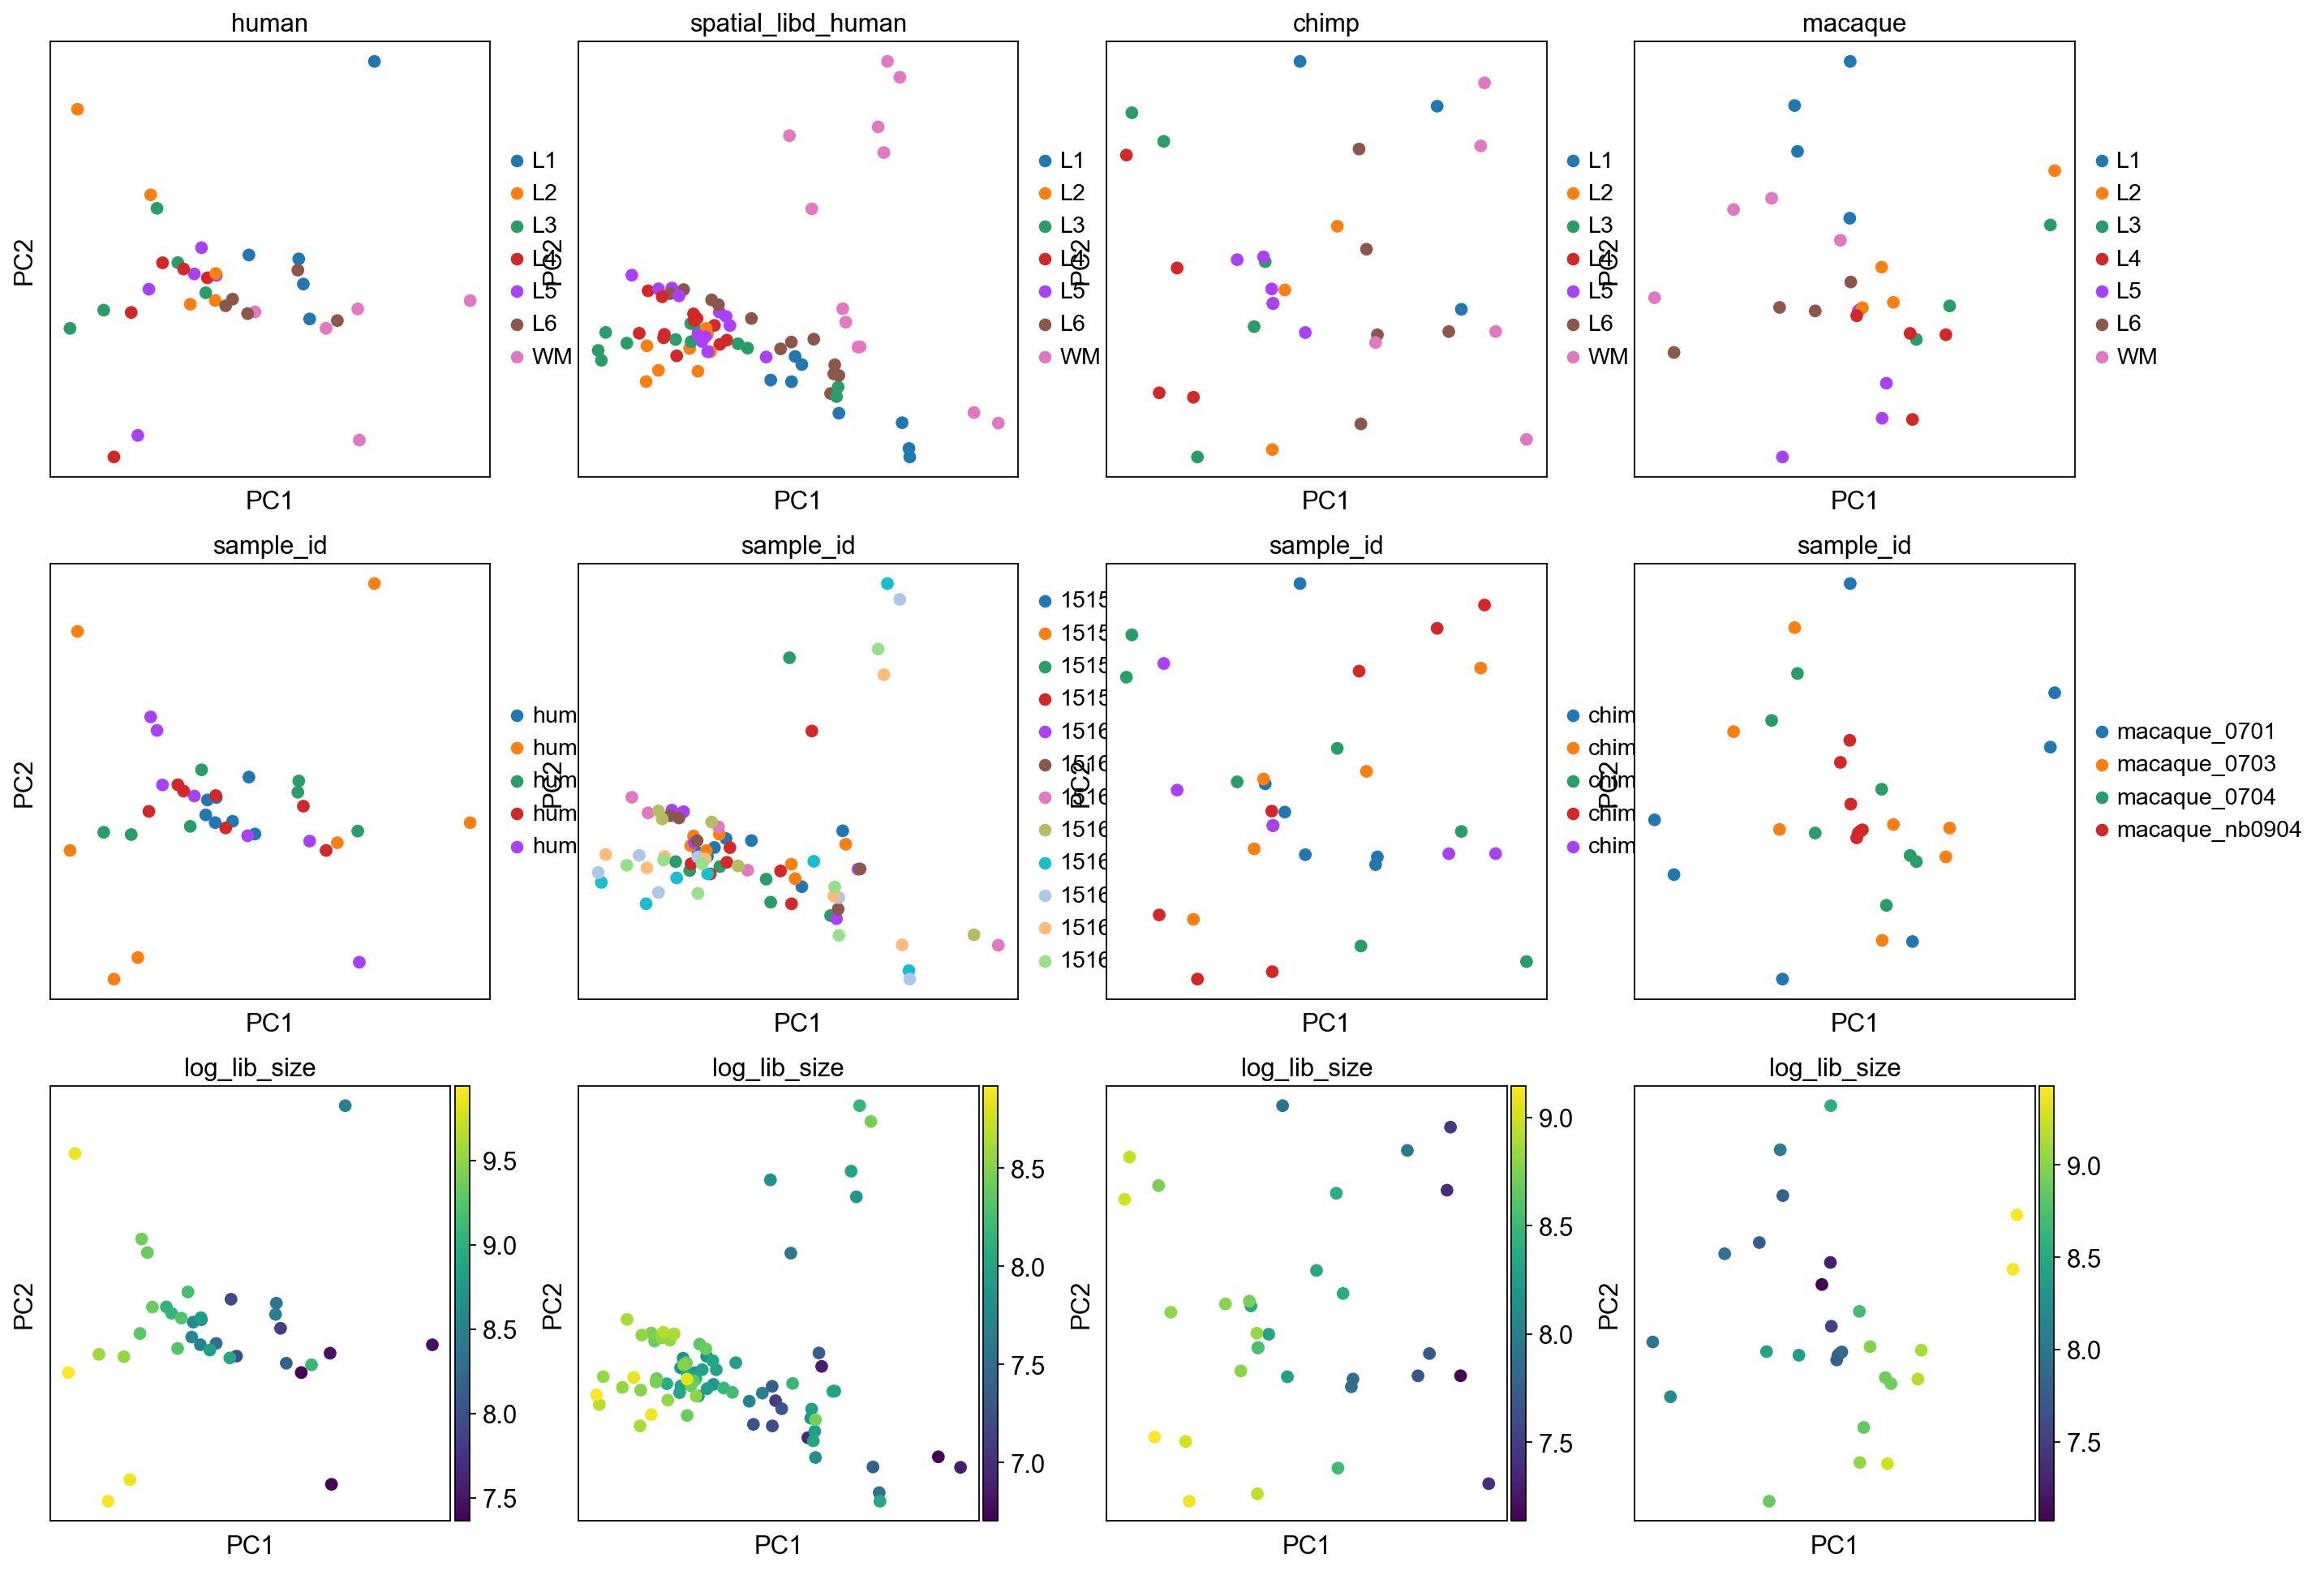

In [97]:
fig, ax = plt.subplots(3, 4, figsize=(20, 15))

for i, condition in enumerate(tqdm(conditions)):
    # load data
    adata = adata_dict[condition + f'_{agg}'].copy()
    adata.obs['sample_id'] = adata.obs['sample_id'].astype(str)
    # calculate lib size
    adata.obs["lib_size"] = adata.X.sum(axis=1)
    adata.obs["log_lib_size"] = np.log(adata.obs["lib_size"])
    # normalize and calculate pca
    adata = subtract_mean(adata)
    sc.pp.pca(adata)
    # plot pca
    sc.pl.pca(adata, color=['layer'], size=200, ax=ax[0][i], show=False, title=condition)
    sc.pl.pca(adata, color=['sample_id'], size=200, ax=ax[1][i], show=False)
    sc.pl.pca(adata, color=['log_lib_size'], size=200, ax=ax[2][i], show=False)

### log(counts) - mean(log(counts))

Аналогично только с логарифмами

In [98]:
adata_pb = adata_pb_dict[agg].copy()
adata_pb.raw = adata_pb

In [99]:
adata_pb.obs["lib_size"] = adata_pb.X.sum(axis=1)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"])

In [100]:
sc.pp.log1p(adata_pb)
adata_norm = subtract_mean(adata_pb)

In [101]:
sc.pp.pca(adata_norm)

computing PCA
    with n_comps=50
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


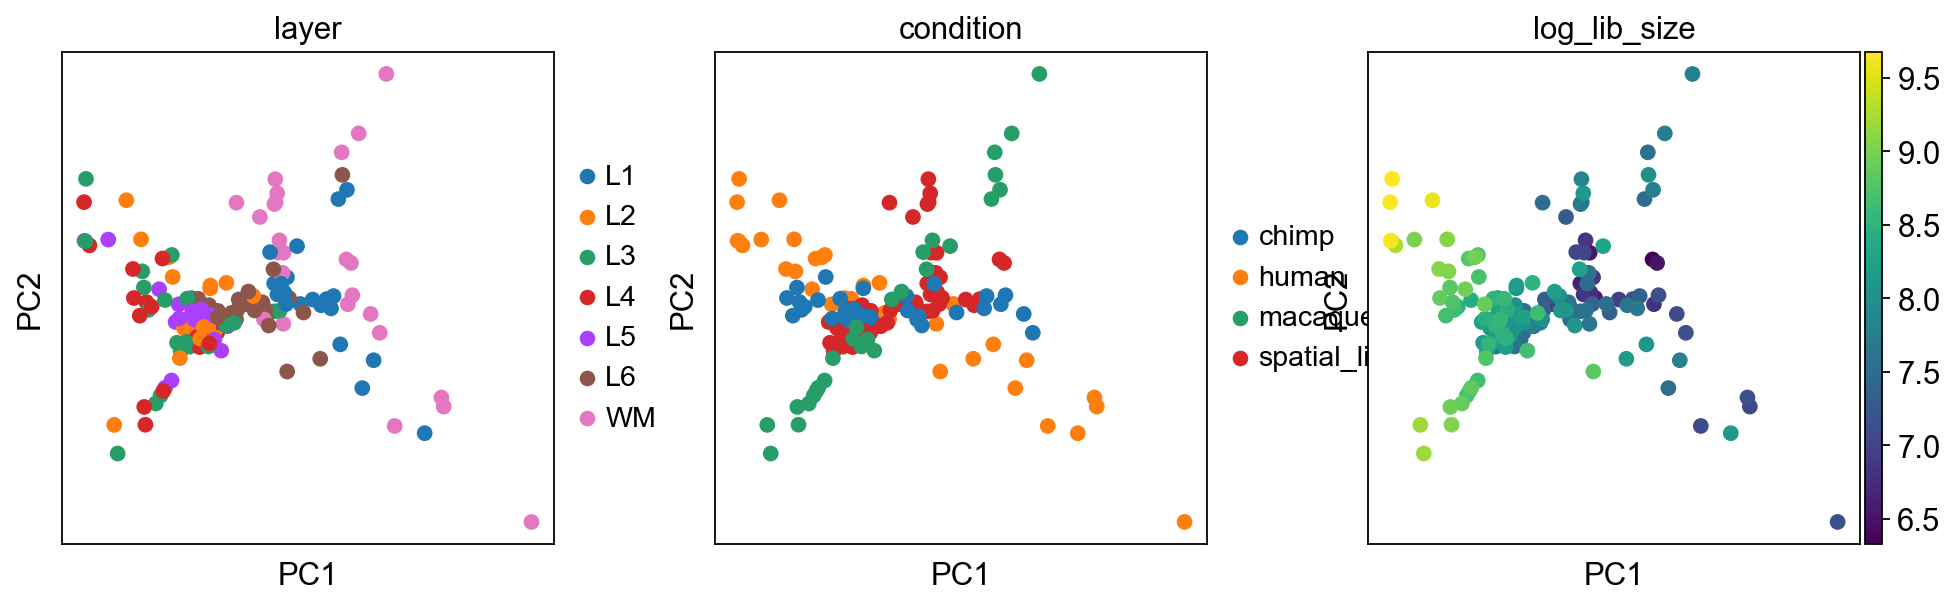

In [102]:
sc.pl.pca(adata_norm, color=['layer', 'condition', 'log_lib_size'], size=200, ncols=3)

  0%|          | 0/4 [00:00<?, ?it/s]

computing PCA
    with n_comps=34
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


computing PCA
    with n_comps=50
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


computing PCA
    with n_comps=30
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


computing PCA
    with n_comps=27
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


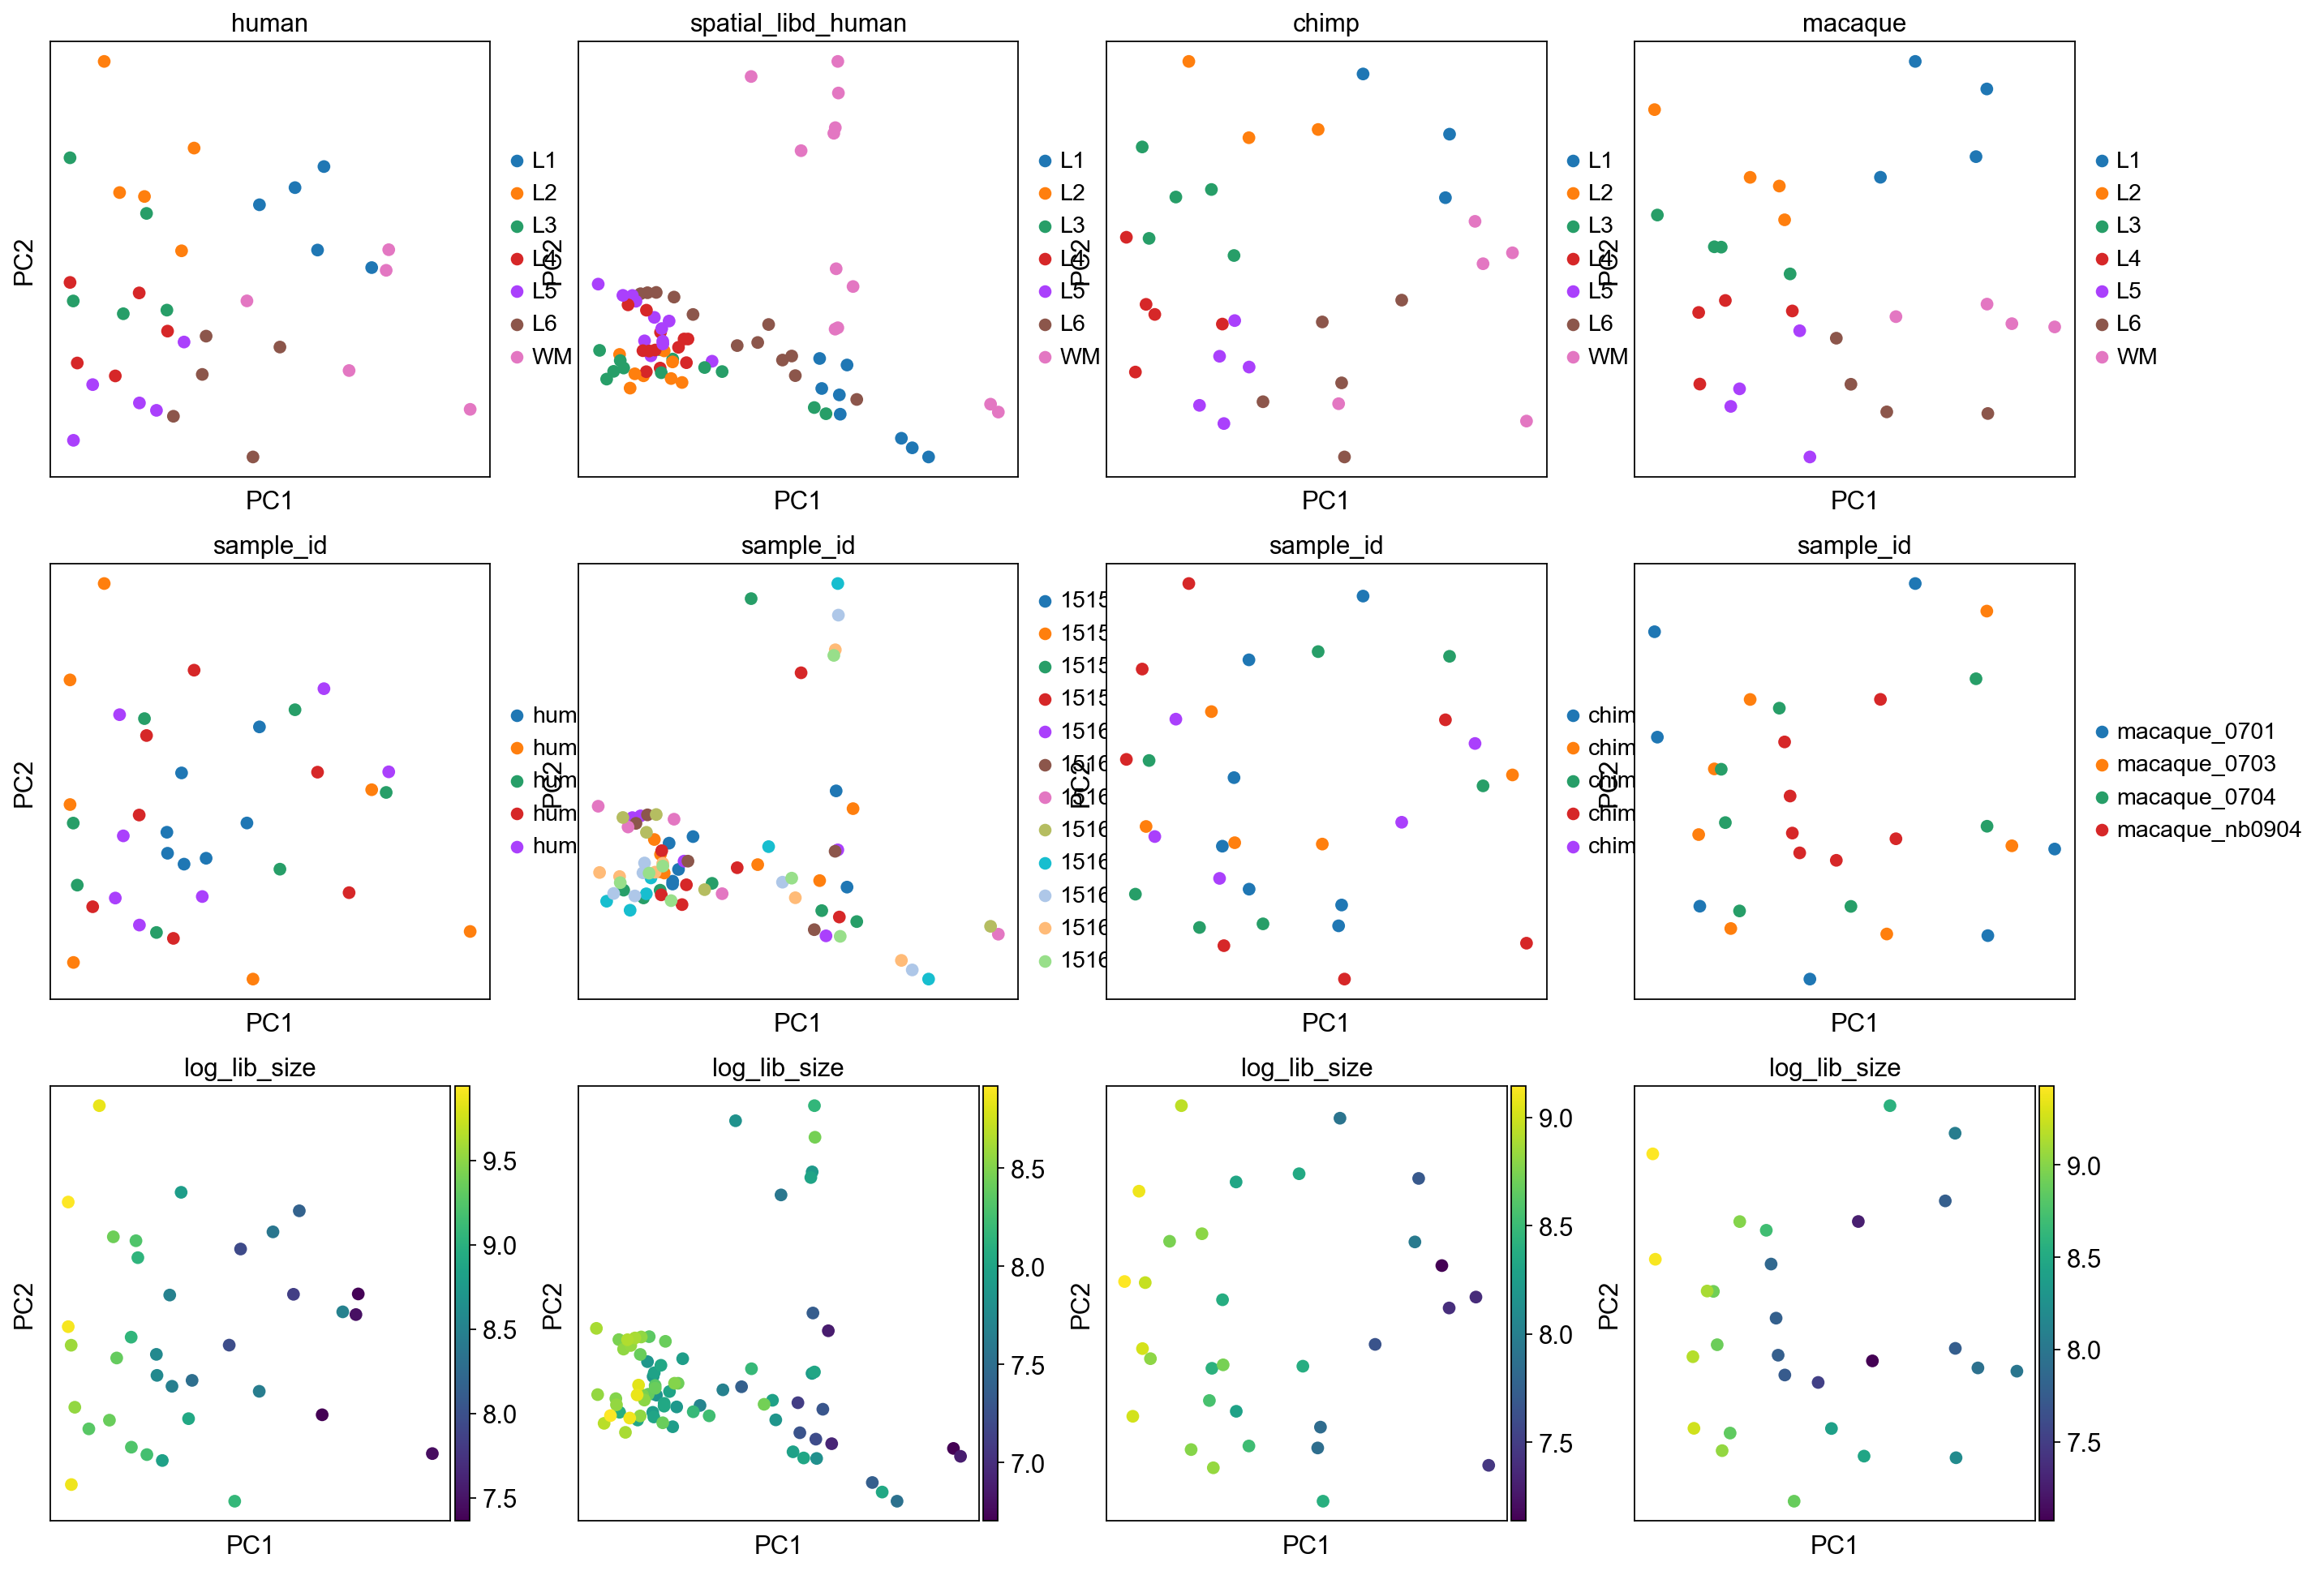

In [103]:
fig, ax = plt.subplots(3, 4, figsize=(20, 15))

for i, condition in enumerate(tqdm(conditions)):
    # load data
    adata = adata_dict[condition + f'_{agg}'].copy()
    adata.obs['sample_id'] = adata.obs['sample_id'].astype(str)
    # calculate lib size
    adata.obs["lib_size"] = adata.X.sum(axis=1)
    adata.obs["log_lib_size"] = np.log(adata.obs["lib_size"])
    # normalize and calculate pca
    sc.pp.log1p(adata)
    adata = subtract_mean(adata)
    sc.pp.pca(adata)
    # plot pca
    sc.pl.pca(adata, color=['layer'], size=200, ax=ax[0][i], show=False, title=condition)
    sc.pl.pca(adata, color=['sample_id'], size=200, ax=ax[1][i], show=False)
    sc.pl.pca(adata, color=['log_lib_size'], size=200, ax=ax[2][i], show=False)

### log(CPM) - mean_pb(log(CPM)) 

Аналогично только для логарифм нормализованых на глубину секвенирования

In [104]:
adata_pb = adata_pb_dict[agg].copy()
adata_pb.raw = adata_pb

In [105]:
adata_pb.obs["lib_size"] = adata_pb.X.sum(axis=1)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"])

In [106]:
sc.pp.normalize_total(adata_pb, target_sum=1e4)
sc.pp.log1p(adata_pb)
adata_norm = subtract_mean(adata_pb)

normalizing counts per cell
    finished (0:00:00)


In [107]:
sc.pp.pca(adata_norm)

computing PCA
    with n_comps=50
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


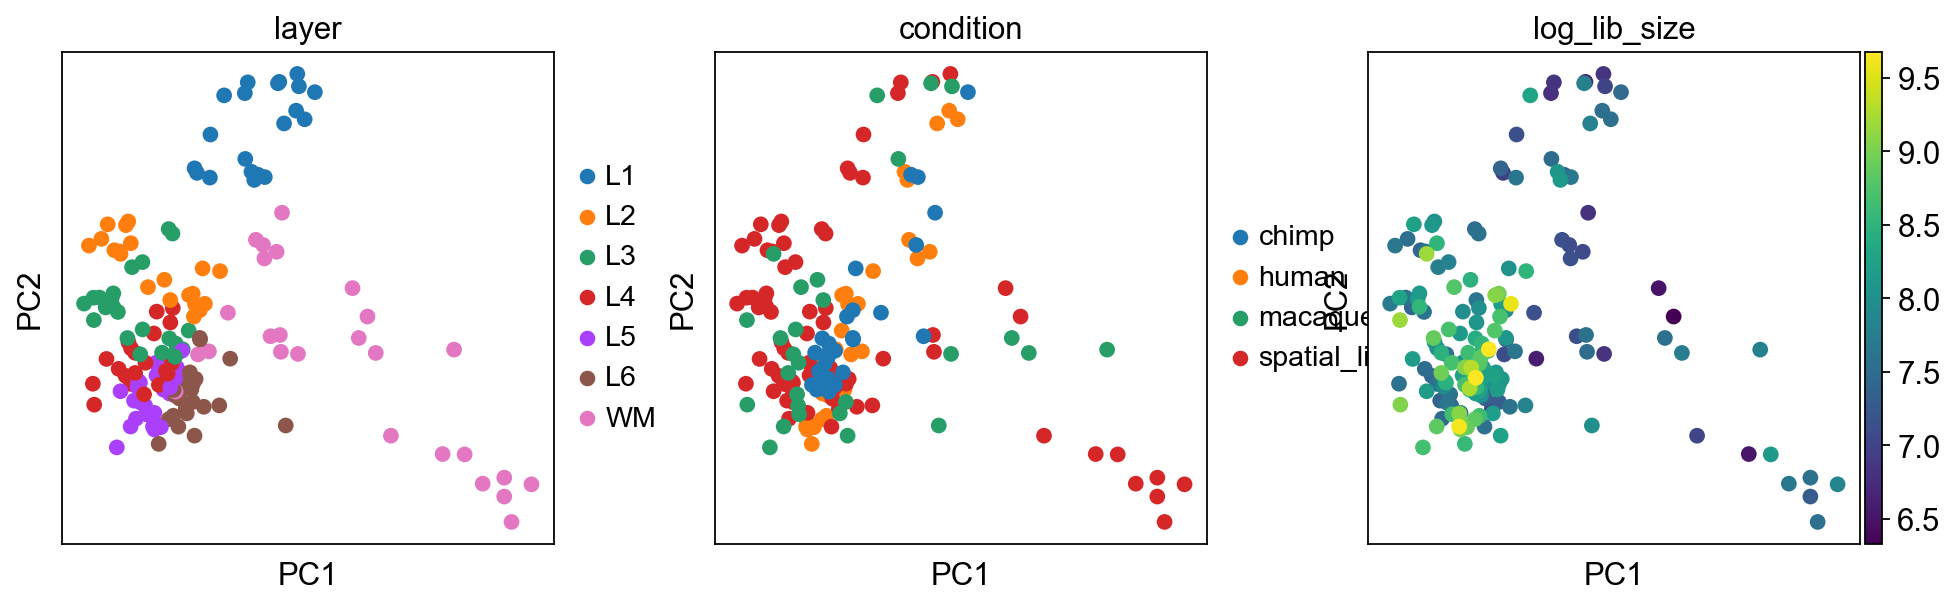

In [108]:
sc.pl.pca(adata_norm, color=['layer', 'condition', 'log_lib_size'], size=200, ncols=3)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


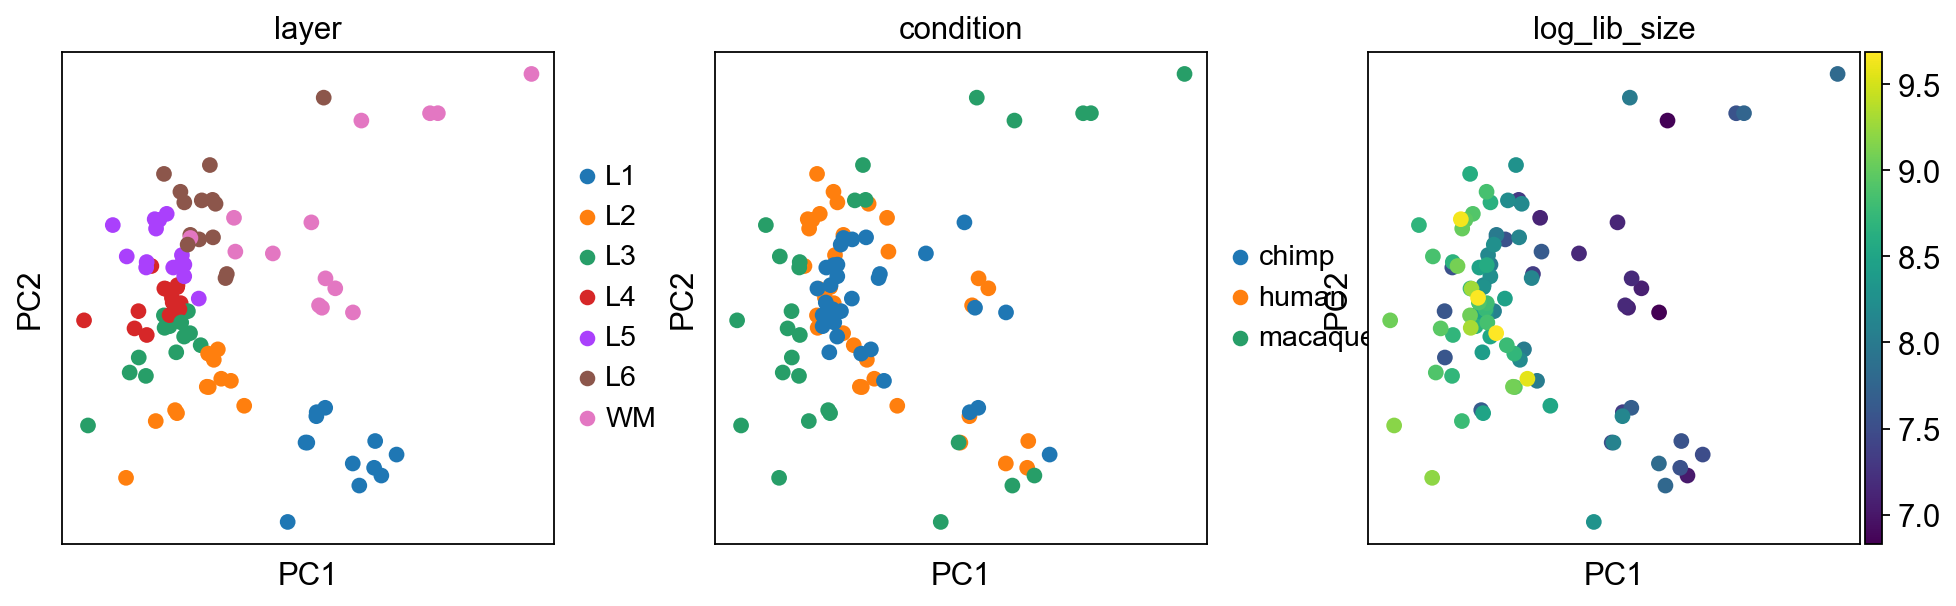

In [115]:
adata_pb = adata_pb_dict['mamm_mean'].copy()
adata_pb.raw = adata_pb

adata_pb.obs["lib_size"] = adata_pb.X.sum(axis=1)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"])

sc.pp.normalize_total(adata_pb, target_sum=1e4)
sc.pp.log1p(adata_pb)
adata_norm = subtract_mean(adata_pb)
sc.pp.pca(adata_norm)
adata_norm.write_h5ad('../data/pseudobulks/pb_mamm_sample_norm.h5ad')

sc.pl.pca(adata_norm, color=['layer', 'condition', 'log_lib_size'], size=200, ncols=3)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


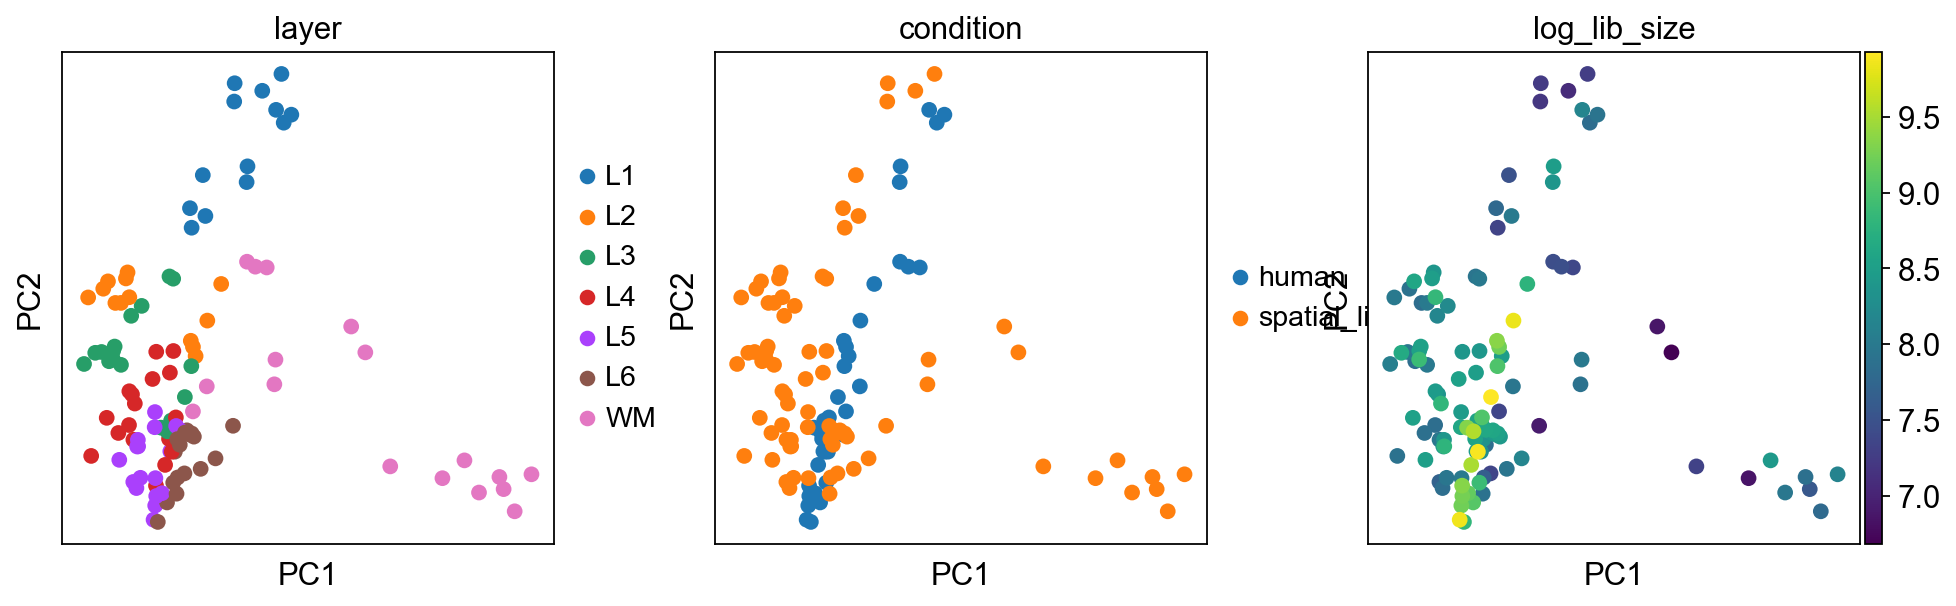

In [116]:
adata_pb = adata_pb_dict['age_mean'].copy()
adata_pb.raw = adata_pb

adata_pb.obs.sample_id = adata_pb.obs.sample_id.astype(str)
adata_pb.obs["lib_size"] = adata_pb.X.sum(axis=1)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"])

sc.pp.normalize_total(adata_pb, target_sum=1e4)
sc.pp.log1p(adata_pb)
adata_norm = subtract_mean(adata_pb)
sc.pp.pca(adata_norm)
adata_norm.write_h5ad('../data/pseudobulks/pb_age_sample_norm.h5ad')

sc.pl.pca(adata_norm, color=['layer', 'condition', 'log_lib_size'], size=200, ncols=3)

  0%|          | 0/4 [00:00<?, ?it/s]

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=34
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


computing PCA
    with n_comps=30
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


computing PCA
    with n_comps=27
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


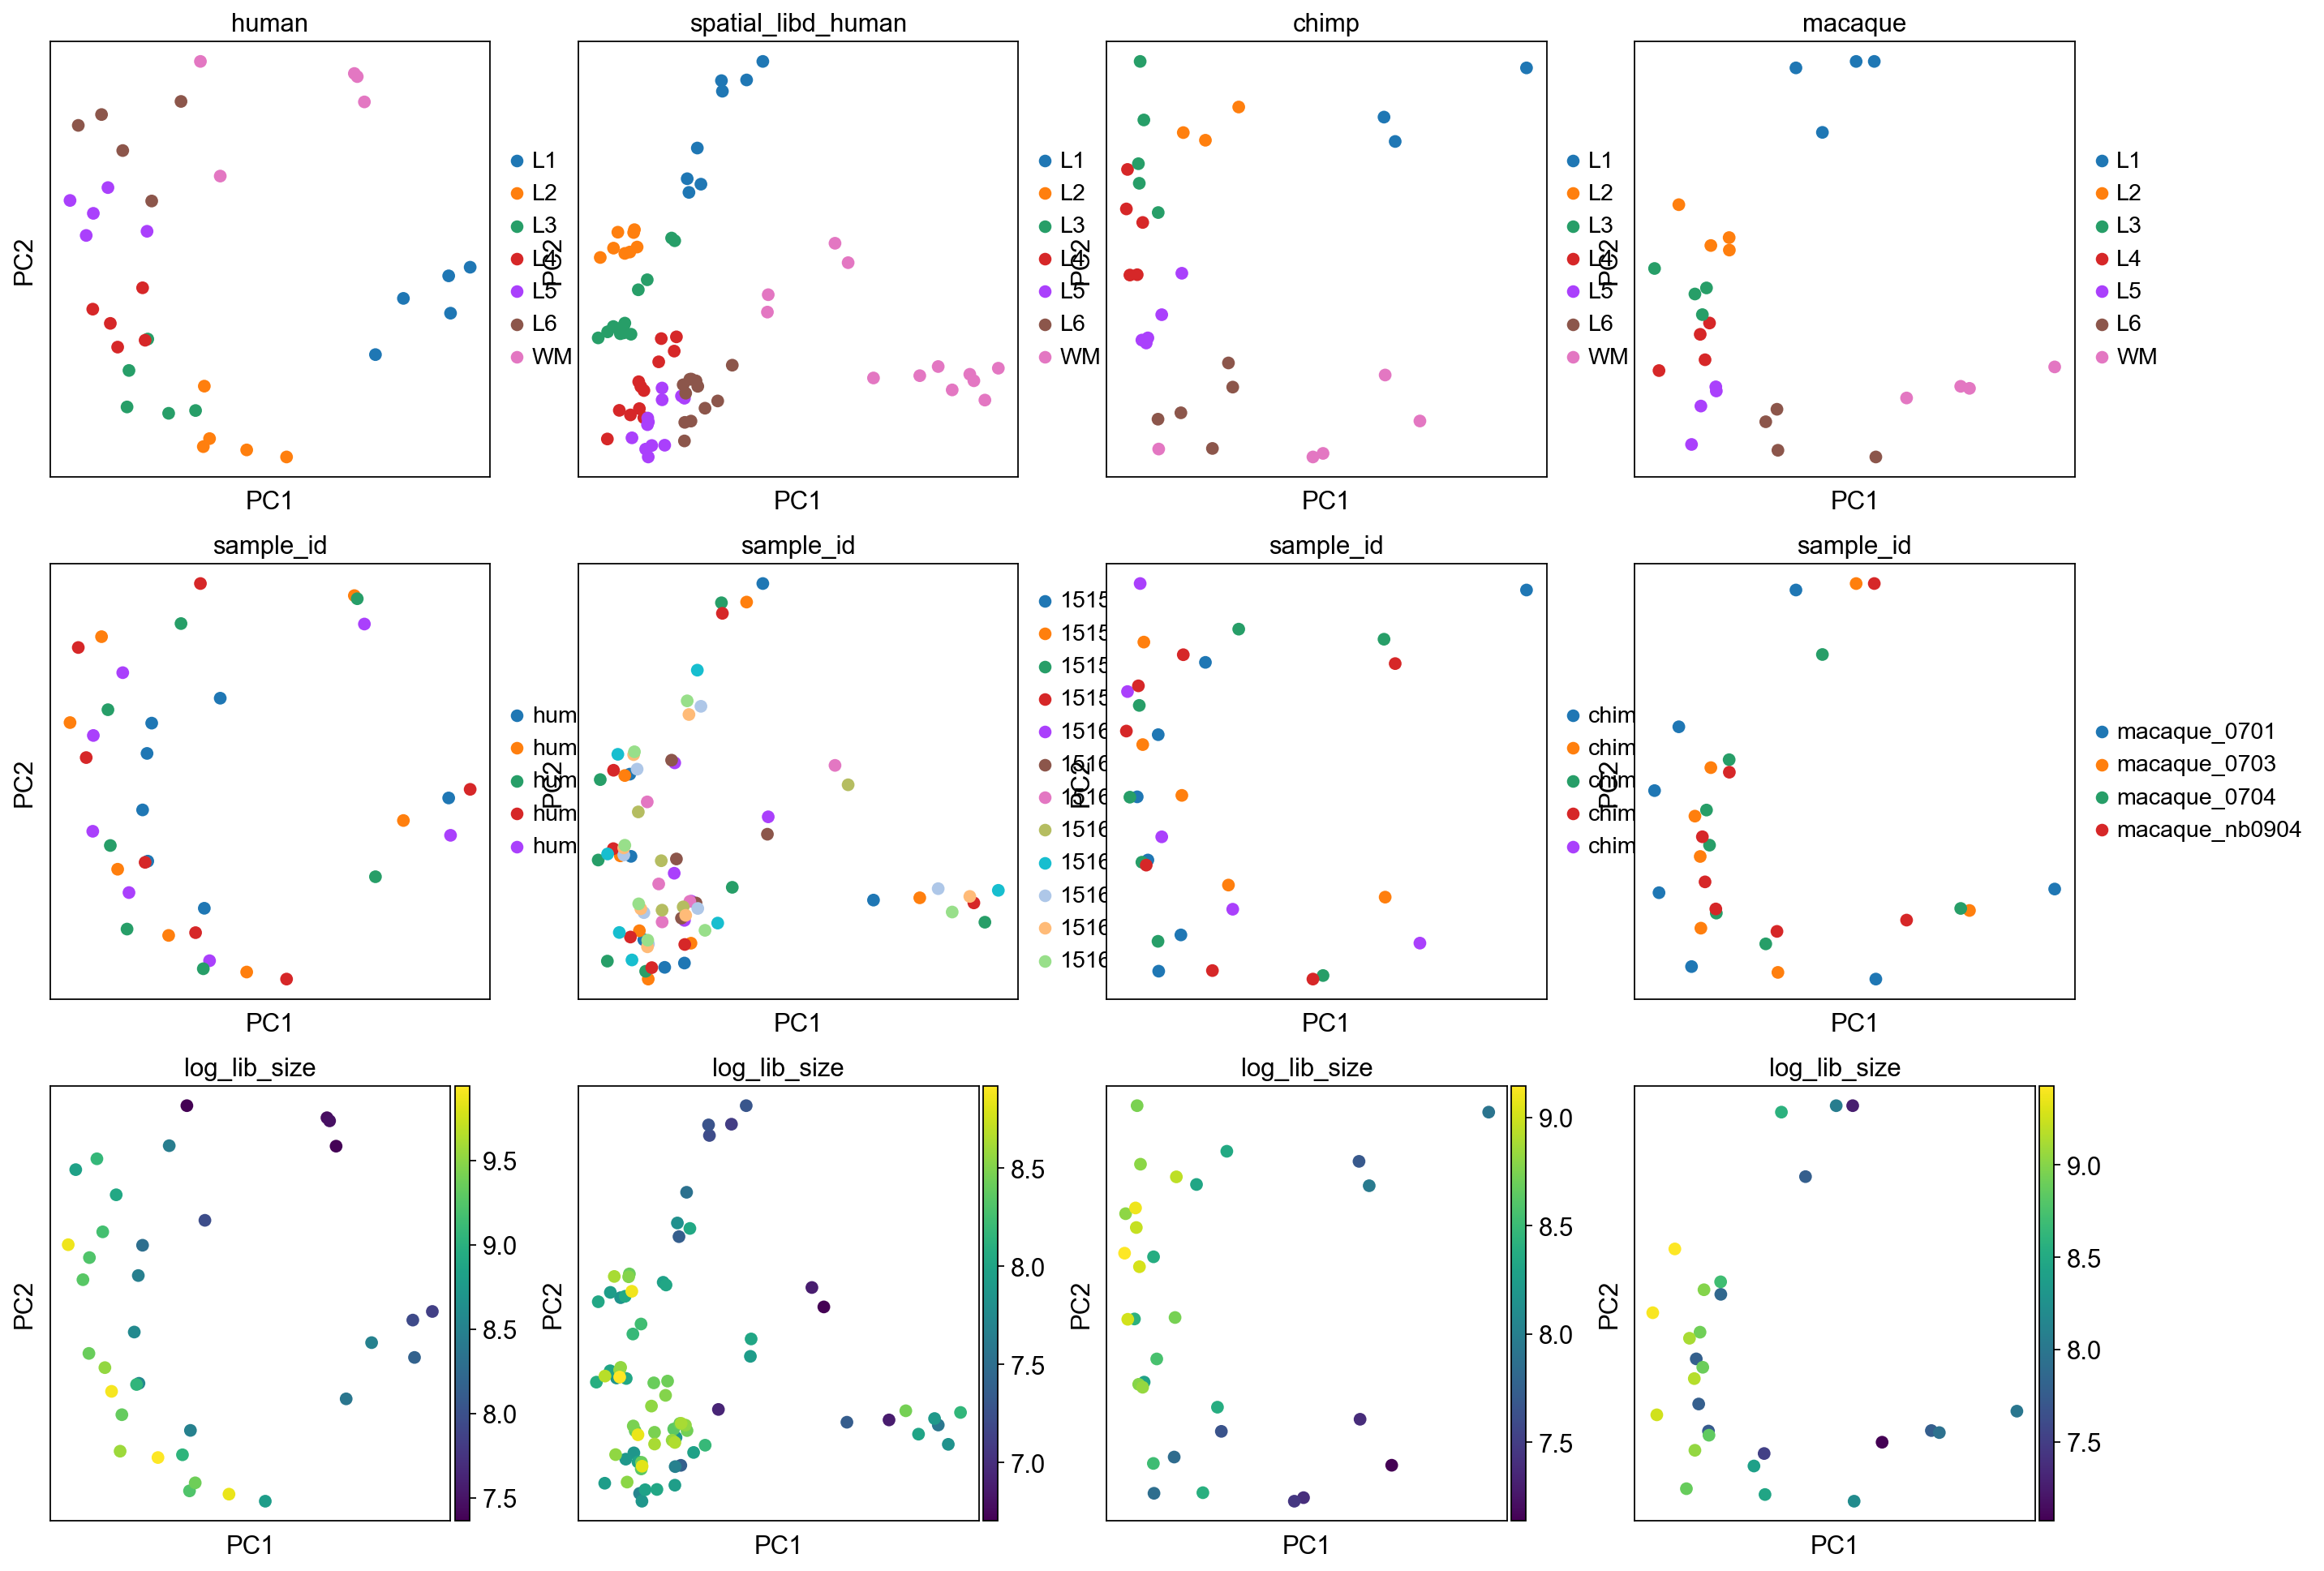

In [117]:
fig, ax = plt.subplots(3, 4, figsize=(20, 15))

for i, condition in enumerate(tqdm(conditions)):
    # load data
    adata = adata_dict[condition + f'_{agg}'].copy()
    adata.obs['sample_id'] = adata.obs['sample_id'].astype(str)
    # calculate lib size
    adata.obs["lib_size"] = adata.X.sum(axis=1)
    adata.obs["log_lib_size"] = np.log(adata.obs["lib_size"])
    # normalize and calculate pca
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = subtract_mean(adata)
    sc.pp.pca(adata)
    # plot pca
    sc.pl.pca(adata, color=['layer'], size=200, ax=ax[0][i], show=False, title=condition)
    sc.pl.pca(adata, color=['sample_id'], size=200, ax=ax[1][i], show=False)
    sc.pl.pca(adata, color=['log_lib_size'], size=200, ax=ax[2][i], show=False)

### z_score(log(CPM))

Делим ещё на корень из дисперсии

In [180]:
def z_score(adata):
    pb_df = pd.DataFrame(adata.X, columns=adata.var_names, index=adata.obs_names)
    pb_df['sample_id'] = adata.obs['sample_id']
    pb_df.head()
    # calculate statistics
    sample_mean = pb_df.groupby('sample_id').mean()
    sample_std = pb_df.groupby('sample_id').std()
    # calculate z-score
    columns = pb_df.columns.tolist()[:-1]
    for sample in tqdm(sample_mean.index.tolist()):
        pb_df.loc[pb_df.sample_id == sample, columns] = ((pb_df.loc[pb_df.sample_id == sample, columns] - sample_mean.loc[sample])
                                                         / sample_std.loc[sample]).fillna(0)
    # write adata
    adata.X = pb_df[columns].values
    return adata

In [181]:
adata_norm = adata_pb_dict[agg].copy()

In [182]:
adata_norm.obs["lib_size"] = adata_norm.X.sum(axis=1)
adata_norm.obs["log_lib_size"] = np.log(adata_norm.obs["lib_size"])

In [183]:
sc.pp.normalize_total(adata_norm, target_sum=1e4)
sc.pp.log1p(adata_norm)

normalizing counts per cell
    finished (0:00:00)


In [184]:
adata_norm = z_score(adata_norm)

  0%|          | 0/26 [00:00<?, ?it/s]

In [185]:
sc.pp.pca(adata_norm)

computing PCA
    with n_comps=50
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


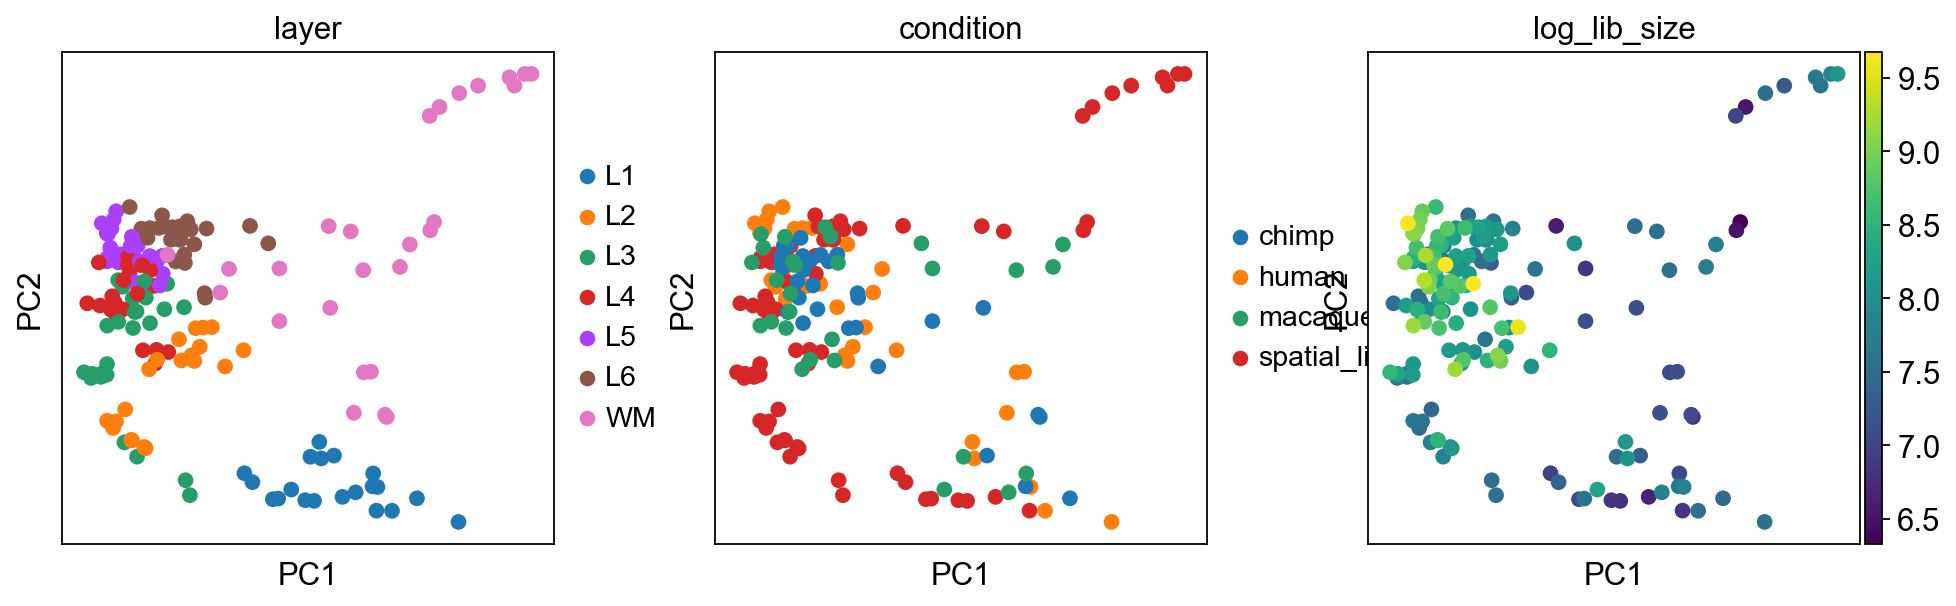

In [186]:
sc.pl.pca(adata_norm, color=['layer', 'condition', 'log_lib_size'], size=200, ncols=3)

normalizing counts per cell
    finished (0:00:00)


  0%|          | 0/14 [00:00<?, ?it/s]

computing PCA
    with n_comps=50
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


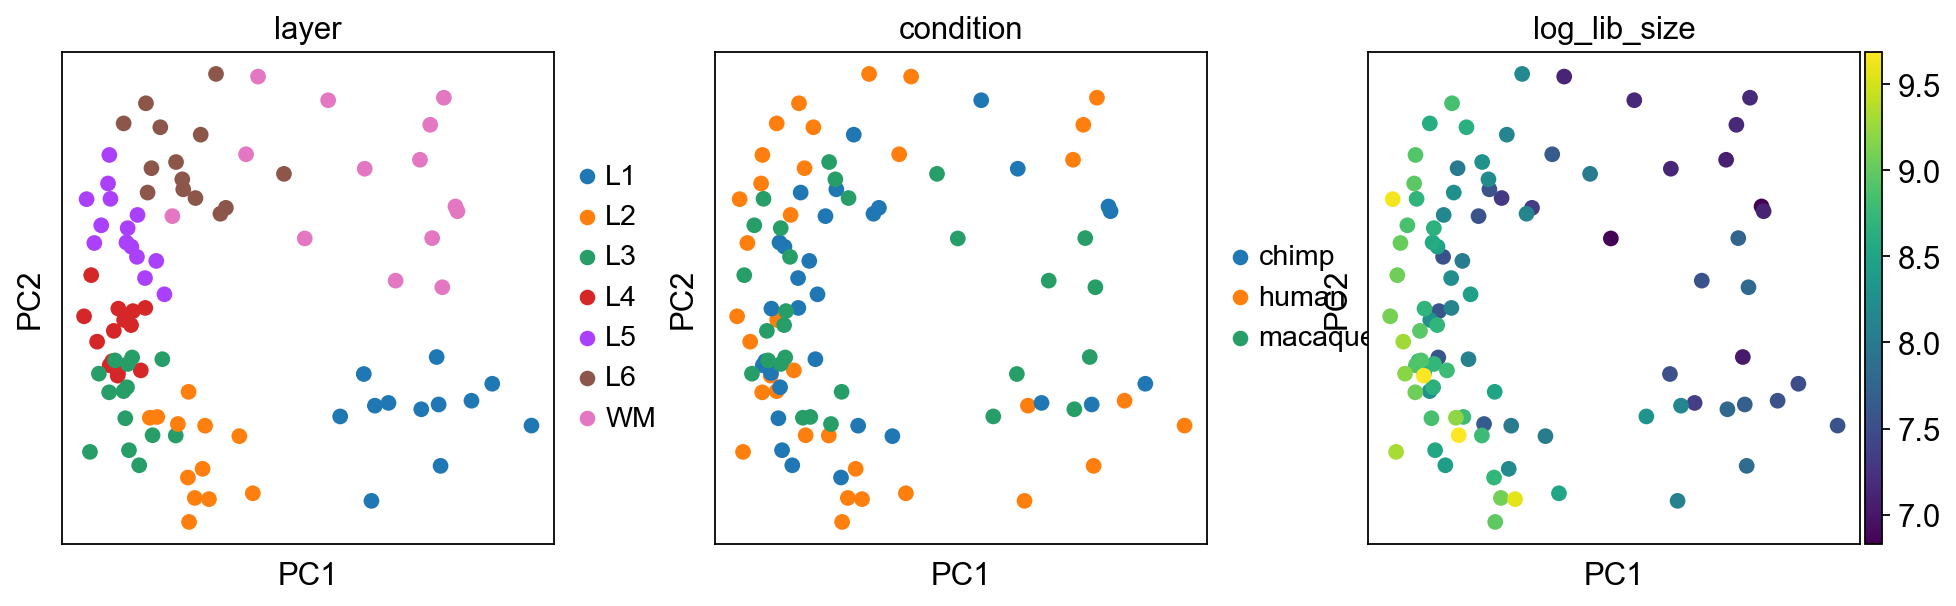

In [187]:
adata_pb = adata_pb_dict['mamm_mean'].copy()
adata_pb.raw = adata_pb

adata_pb.obs["lib_size"] = adata_pb.X.sum(axis=1)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"])

sc.pp.normalize_total(adata_pb, target_sum=1e4)
sc.pp.log1p(adata_pb)
adata_norm = z_score(adata_pb)
sc.pp.pca(adata_norm)
adata_norm.write_h5ad('../data/pseudobulks/pb_mamm_sample_norm_zscore.h5ad')

sc.pl.pca(adata_norm, color=['layer', 'condition', 'log_lib_size'], size=200, ncols=3)

normalizing counts per cell
    finished (0:00:00)


  0%|          | 0/17 [00:00<?, ?it/s]

computing PCA
    with n_comps=50
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


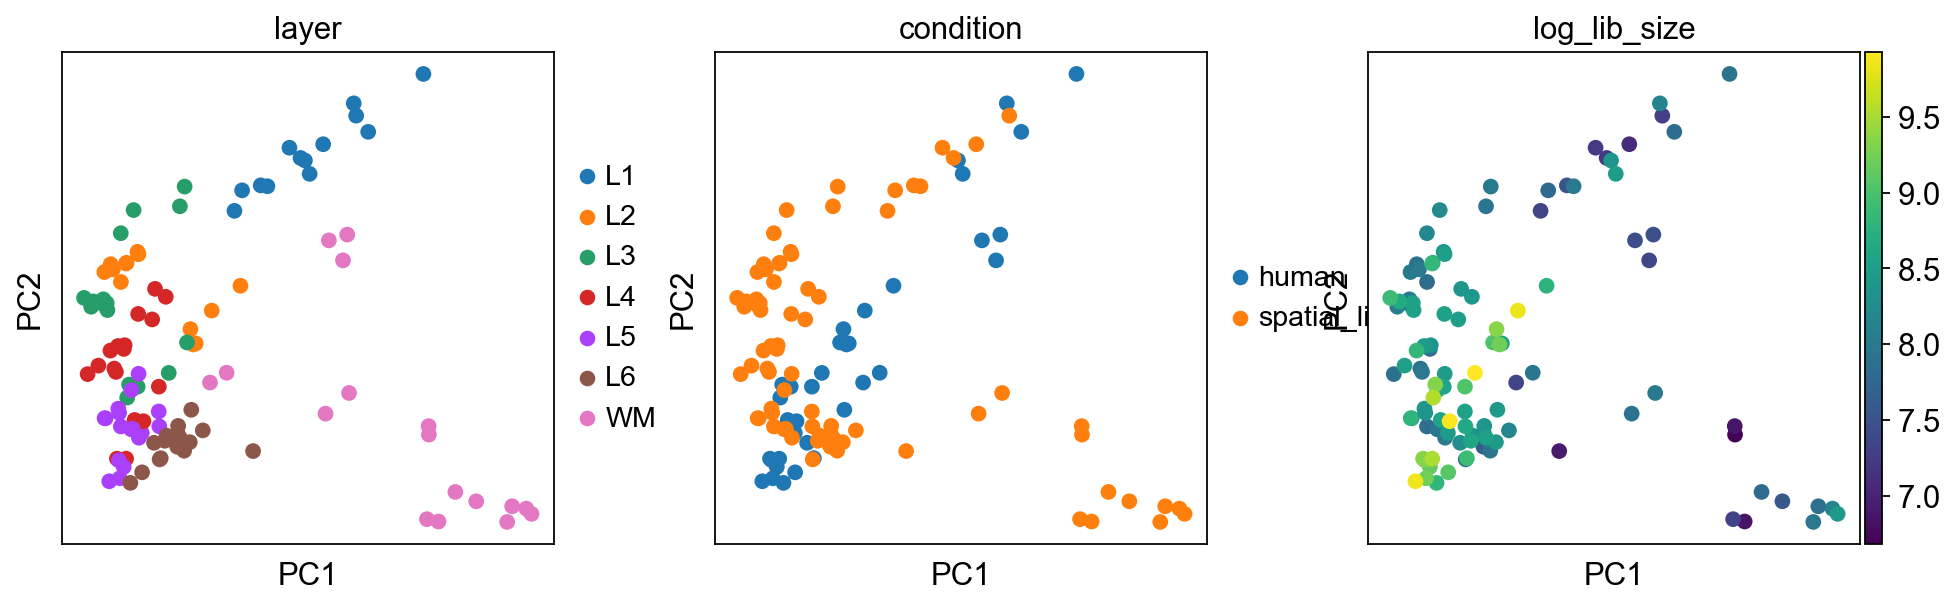

In [188]:
adata_pb = adata_pb_dict['age_mean'].copy()
adata_pb.raw = adata_pb

adata_pb.obs.sample_id = adata_pb.obs.sample_id.astype(str)
adata_pb.obs["lib_size"] = adata_pb.X.sum(axis=1)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"])

sc.pp.normalize_total(adata_pb, target_sum=1e4)
sc.pp.log1p(adata_pb)
adata_norm = z_score(adata_pb)
sc.pp.pca(adata_norm)
adata_norm.write_h5ad('../data/pseudobulks/pb_age_sample_norm_zscore.h5ad')

sc.pl.pca(adata_norm, color=['layer', 'condition', 'log_lib_size'], size=200, ncols=3)

  0%|          | 0/4 [00:00<?, ?it/s]

normalizing counts per cell
    finished (0:00:00)


  0%|          | 0/5 [00:00<?, ?it/s]

computing PCA
    with n_comps=34
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


normalizing counts per cell
    finished (0:00:00)


  0%|          | 0/12 [00:00<?, ?it/s]

computing PCA
    with n_comps=50
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


normalizing counts per cell
    finished (0:00:00)


  0%|          | 0/5 [00:00<?, ?it/s]

computing PCA
    with n_comps=30
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


normalizing counts per cell
    finished (0:00:00)


  0%|          | 0/4 [00:00<?, ?it/s]

computing PCA
    with n_comps=27
    finished (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


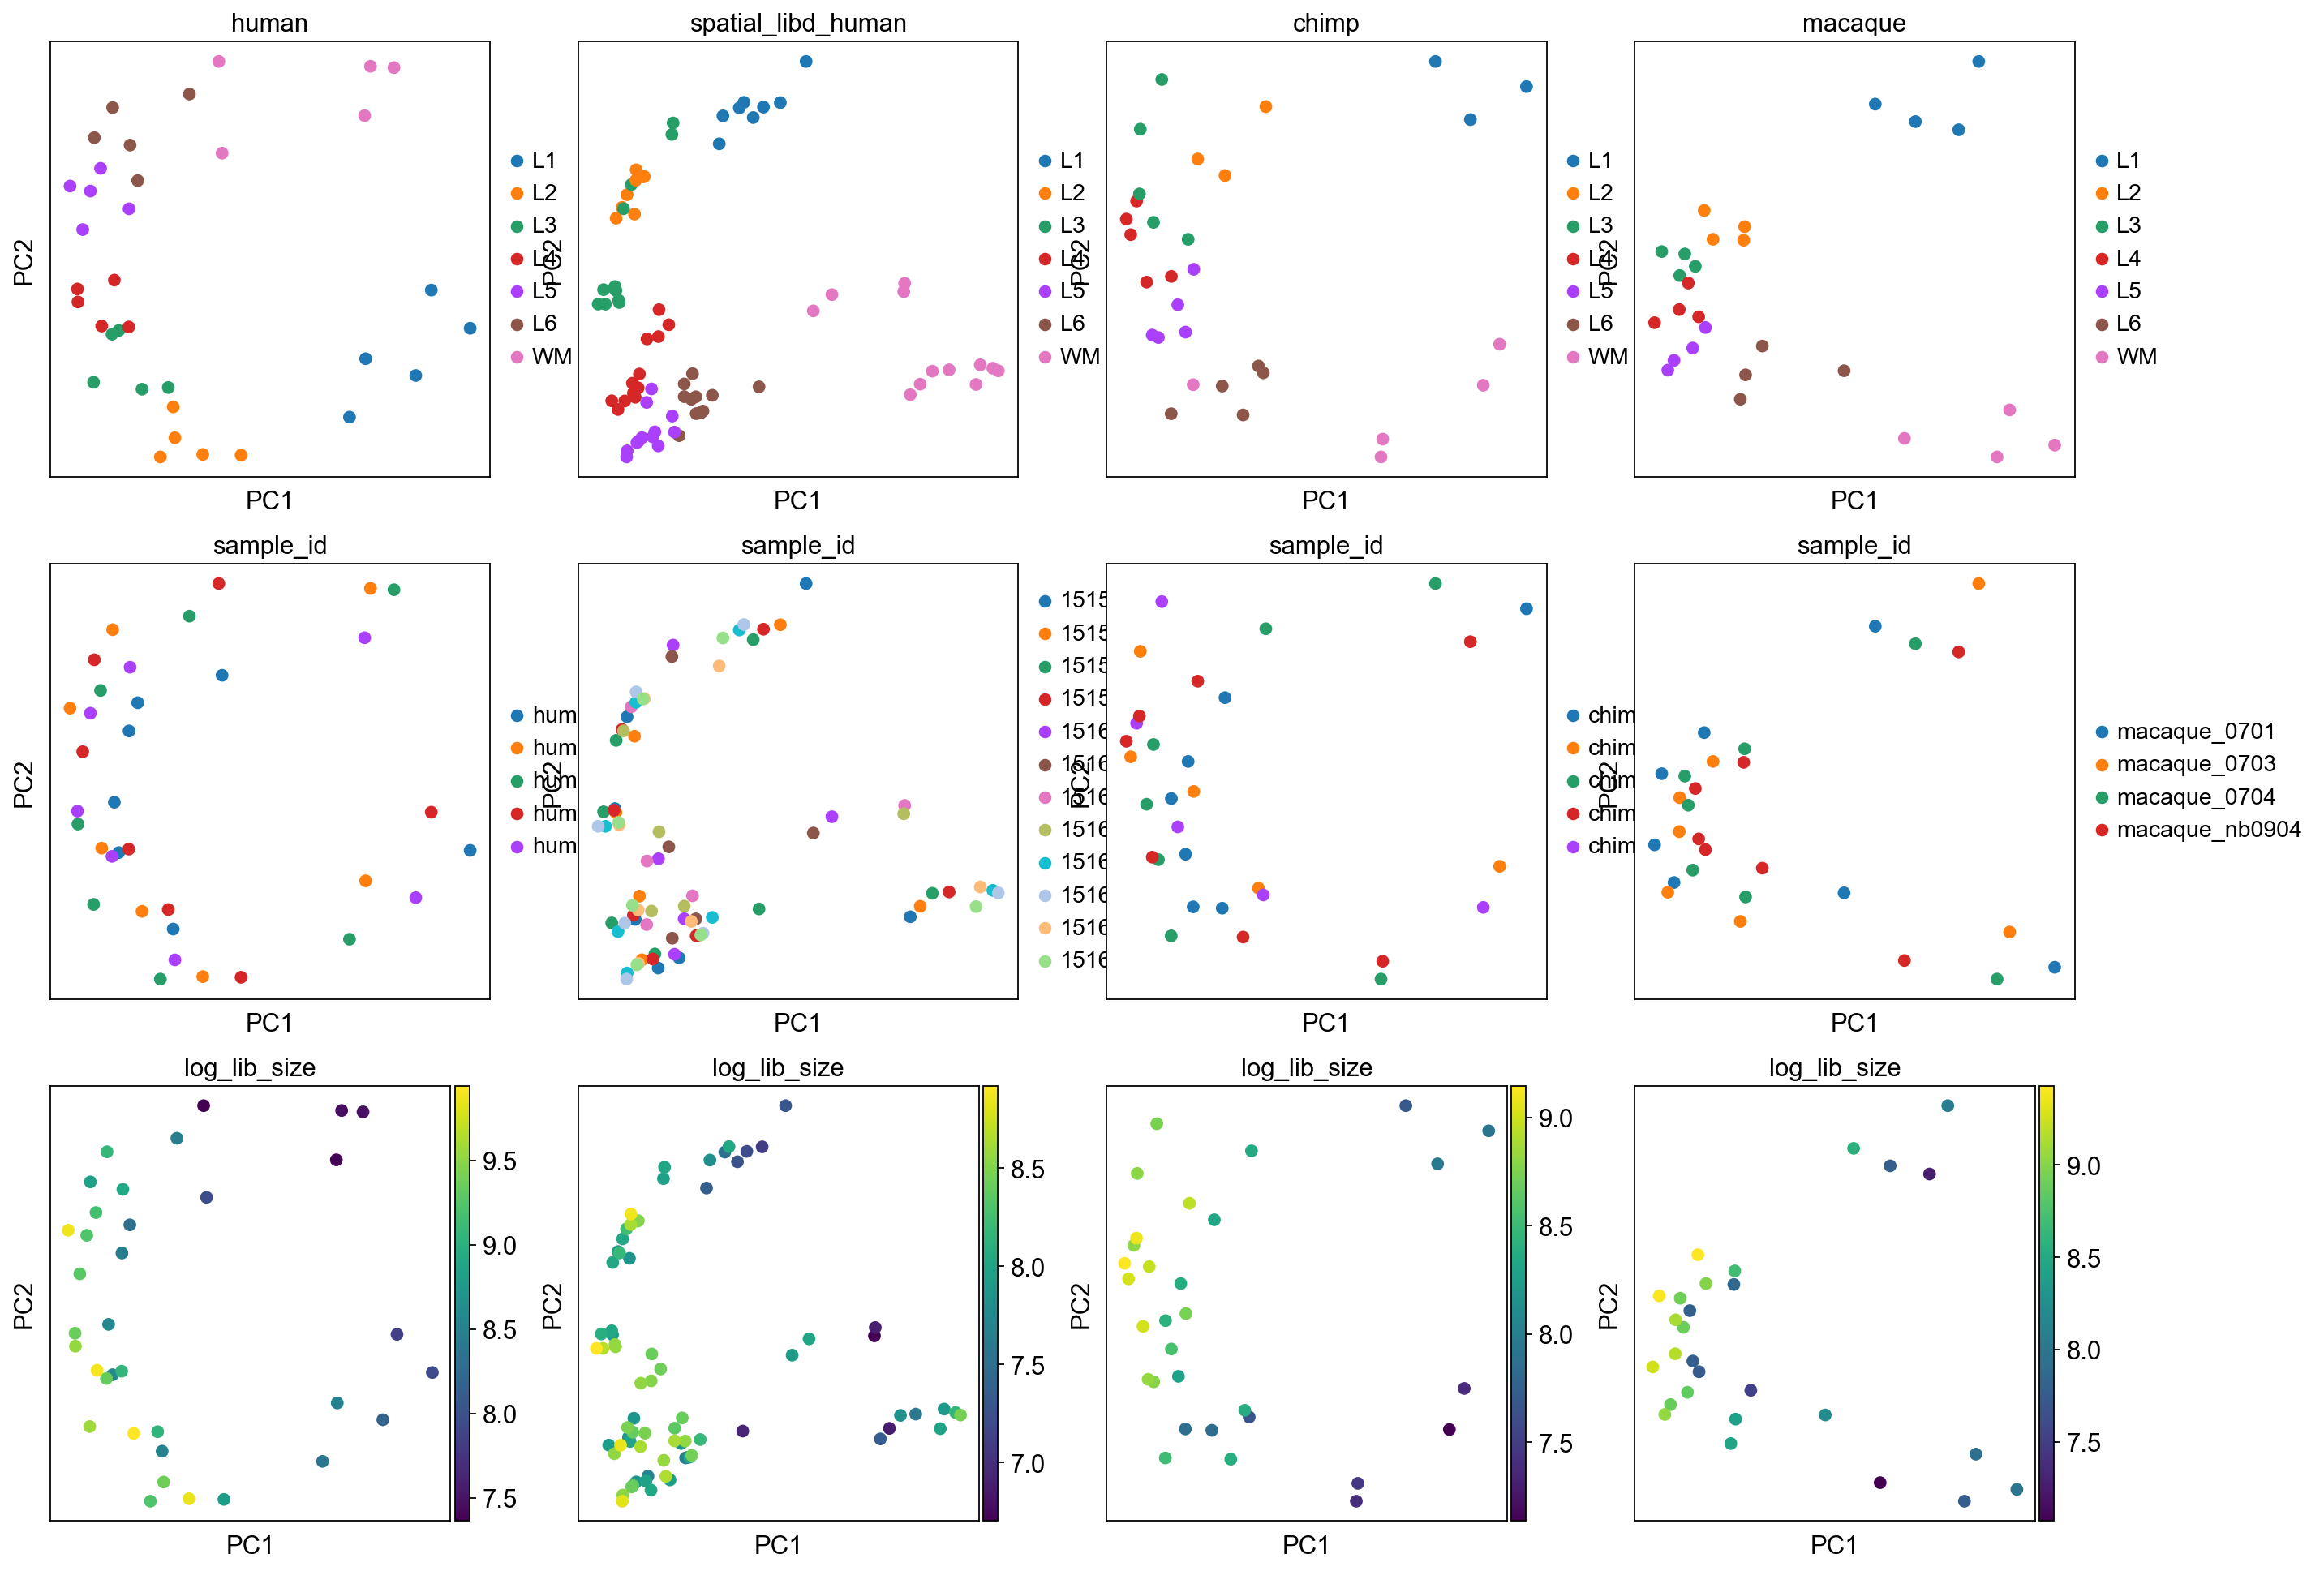

In [189]:
fig, ax = plt.subplots(3, 4, figsize=(20, 15))

for i, condition in enumerate(tqdm(conditions)):
    # load data
    adata = adata_dict[condition + f'_{agg}'].copy()
    adata.obs['sample_id'] = adata.obs['sample_id'].astype(str)
    # calculate lib size
    adata.obs["lib_size"] = adata.X.sum(axis=1)
    adata.obs["log_lib_size"] = np.log(adata.obs["lib_size"])
    # normalize and calculate pca
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = z_score(adata)
    sc.pp.pca(adata)
    # plot pca
    sc.pl.pca(adata, color=['layer'], size=200, ax=ax[0][i], show=False, title=condition)
    sc.pl.pca(adata, color=['sample_id'], size=200, ax=ax[1][i], show=False)
    sc.pl.pca(adata, color=['log_lib_size'], size=200, ax=ax[2][i], show=False)